# Contents


[Missing Data](#Missing-Data)

[Data Types](#Data-Types)
- address why I reclassified (or did not reclassify) certain features (OverallCond, OverallQual) 

[Outlier Analysis](#Outlier-Analysis)
- Explore how best to handle outliers for modeling
- From data dictionary "There are five observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will quickly indicate these points). Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these five unusual observations) before assigning it to students."

[Data Imputation](#Data-Imputation)

[Feature Engineering](#Feature-Engineering)
- Area and SF features

[Log transformations](#Log-transformations)
- Comparing SalePrice and Log(SalePrice) for linear modeling

[Categorical feature analysis](#Categorical-feature-analysis)

[Multicollinearity](#Multicollinearity)
- VIF scores
 
[OverallQual and OverallCond](#OverallQual-and-OverallCond)

[Resources](#Resources)

**Notes on:**



**Multicollinearity** (feature engineering)
- ID most problematic features (heatmaps, Lasso for this)
- adjust features with feature engineering; feed into Ridge, Lasso, EN
- tune parameters… Optuna?
- look at how feature coeffs vary across folds (exploring model stability)
- do this for the features I am considering engineering using Lasso (w scaled features) on multicollinear features to see which ones to drop; or inform about feature engineering? 
- tuning alpha to see how coeff variances changes with penalization

- VIF > 5 or > 10, highly correlated to features in the feature set.
https://www.datacamp.com/tutorial/variance-inflation-factor

- heatmap: find high correlations… > 5, or 10, problematic… 
look at after I have narrowed some features; can do early too.
but mulitcollinearity is dynamic, so as you remove features, it can change.
use other methods to cull features before looking at VIF. 
one of the last steps to run, after i have narrowed feature set down.
vif, heatmaps. lasso all point in same direction.

**Feature Engineering** (is this a separate step from exploring multicollinearity?)
- how does model improve with engineered area features? 
- Use Lasso/tree models to see how engineered/non-engineered features are treated? 
- run MLR with different area feature combinations to find best R2:
1. GrLivArea; (without separate area features)
2. 1stFlrSF, 2ndFlrSF + basement feature (no GrLivArea)
3. engineered area features?
- find best combos of features to predict sale price… 
- what should stay in, what should be combined, what should be dropped? 
- leave in GrLivArea, or the 1stFlrSF, etc feats that make up GrLivArea?
- does the model benefit from complexity or simplicity?

**Feature Selection** (to determine which features are most essential for model) 
- Sequential Feature Selector (for both numeric and categorical features?)
- Lasso
- RandomForest → feature importances (tress are their own models: don't use for MLR modeling... apples and oranges) 

In [4]:
# import libraries
import pandas as pd
import numpy as np
import pandas as pd

In [5]:
ames_raw = pd.read_csv('Ames_Housing_Price_Data.csv', index_col=0).reset_index()

In [6]:
ames_raw.drop(columns=['index'], inplace=True)

In [7]:
ames_raw

PID  GrLivArea  SalePrice  MSSubClass MSZoning  LotFrontage  \
0     909176150        856     126000          30       RL          NaN   
1     905476230       1049     139500         120       RL         42.0   
2     911128020       1001     124900          30  C (all)         60.0   
3     535377150       1039     114000          70       RL         80.0   
4     534177230       1665     227000          60       RL         70.0   
...         ...        ...        ...         ...      ...          ...   
2575  903205040        952     121000          30       RL          NaN   
2576  905402060       1733     139600          20       RL          NaN   
2577  909275030       2002     145000          90       RH         82.0   
2578  907192040       1842     217500          60       RL          NaN   
2579  906223180       1911     215000          60       RL         80.0   

      LotArea Street Alley LotShape  ... ScreenPorch PoolArea PoolQC Fence  \
0        7890   Pave   NaN      Reg  ...         166        0    NaN   NaN   
1        4235   Pave   NaN      Reg  ...           0        0    NaN   NaN   
2        6060   Pave   NaN      Reg  ...           0        0    NaN   NaN   
3        8146   Pave   NaN      Reg  ...         111        0    NaN   NaN   
4        8400   Pave   NaN      Reg  ...           0        0    NaN   NaN   
...       ...    ...   ...      ...  ...         ...      ...    ...   ...   
2575     8854   Pave   NaN      Reg  ...          40        0    NaN   NaN   
2576    13680   Pave   NaN      IR1  ...           0        0    NaN   NaN   
2577     6270   Pave   NaN      Reg  ...           0        0    NaN   NaN   
2578     8826   Pave   NaN      Reg  ...           0        0    NaN   NaN   
2579     9554   Pave   NaN      IR1  ...           0        0    NaN   NaN   

     MiscFeature MiscVal MoSold YrSold SaleType  SaleCondition  
0            NaN       0      3   2010      WD          Normal  
1            NaN       0      2   2009      WD          Normal  
2            NaN       0     11   2007      WD          Normal  
3            NaN       0      5   2009      WD          Normal  
4            NaN       0     11   2009      WD          Normal  
...          ...     ...    ...    ...      ...            ...  
2575         NaN       0      5   2009      WD          Normal  
2576         NaN       0      6   2009      WD          Normal  
2577         NaN       0      8   2007      WD          Normal  
2578         NaN       0      7   2007      WD          Normal  
2579         NaN       0      9   2006      WD          Normal  

[2580 rows x 81 columns]

In [8]:
ames = ames_raw.copy()
ames = ames.drop(columns='PID', axis=1)
ames.shape

(2580, 80)

In [9]:
ames.head()

GrLivArea  SalePrice  MSSubClass MSZoning  LotFrontage  LotArea Street  \
0        856     126000          30       RL          NaN     7890   Pave   
1       1049     139500         120       RL         42.0     4235   Pave   
2       1001     124900          30  C (all)         60.0     6060   Pave   
3       1039     114000          70       RL         80.0     8146   Pave   
4       1665     227000          60       RL         70.0     8400   Pave   

  Alley LotShape LandContour  ... ScreenPorch PoolArea PoolQC Fence  \
0   NaN      Reg         Lvl  ...         166        0    NaN   NaN   
1   NaN      Reg         Lvl  ...           0        0    NaN   NaN   
2   NaN      Reg         Lvl  ...           0        0    NaN   NaN   
3   NaN      Reg         Lvl  ...         111        0    NaN   NaN   
4   NaN      Reg         Lvl  ...           0        0    NaN   NaN   

  MiscFeature MiscVal MoSold YrSold  SaleType  SaleCondition  
0         NaN       0      3   2010       WD          Normal  
1         NaN       0      2   2009       WD          Normal  
2         NaN       0     11   2007       WD          Normal  
3         NaN       0      5   2009       WD          Normal  
4         NaN       0     11   2009       WD          Normal  

[5 rows x 80 columns]

In [10]:
ames.columns

Index(['GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning', 'LotFrontage',
       'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'Pav

In [11]:
ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   GrLivArea      2580 non-null   int64  
 1   SalePrice      2580 non-null   int64  
 2   MSSubClass     2580 non-null   int64  
 3   MSZoning       2580 non-null   object 
 4   LotFrontage    2118 non-null   float64
 5   LotArea        2580 non-null   int64  
 6   Street         2580 non-null   object 
 7   Alley          168 non-null    object 
 8   LotShape       2580 non-null   object 
 9   LandContour    2580 non-null   object 
 10  Utilities      2580 non-null   object 
 11  LotConfig      2580 non-null   object 
 12  LandSlope      2580 non-null   object 
 13  Neighborhood   2580 non-null   object 
 14  Condition1     2580 non-null   object 
 15  Condition2     2580 non-null   object 
 16  BldgType       2580 non-null   object 
 17  HouseStyle     2580 non-null   object 
 18  OverallQ

In [12]:
ames.dtypes.value_counts()

object     43
int64      26
float64    11
Name: count, dtype: int64

### Numerical features

In [14]:
numeric_features = ames.select_dtypes(include=['float64', 'int64'])
numeric_features

GrLivArea  SalePrice  MSSubClass  LotFrontage  LotArea  OverallQual  \
0           856     126000          30          NaN     7890            6   
1          1049     139500         120         42.0     4235            5   
2          1001     124900          30         60.0     6060            5   
3          1039     114000          70         80.0     8146            4   
4          1665     227000          60         70.0     8400            8   
...         ...        ...         ...          ...      ...          ...   
2575        952     121000          30          NaN     8854            6   
2576       1733     139600          20          NaN    13680            3   
2577       2002     145000          90         82.0     6270            5   
2578       1842     217500          60          NaN     8826            7   
2579       1911     215000          60         80.0     9554            8   

      OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  ...  GarageArea  \
0               6       1939          1950         0.0  ...       399.0   
1               5       1984          1984       149.0  ...       266.0   
2               9       1930          2007         0.0  ...       216.0   
3               8       1900          2003         0.0  ...       281.0   
4               6       2001          2001         0.0  ...       528.0   
...           ...        ...           ...         ...  ...         ...   
2575            6       1916          1950         0.0  ...       192.0   
2576            5       1955          1955         0.0  ...       452.0   
2577            6       1949          1950         0.0  ...       871.0   
2578            5       2000          2000       144.0  ...       486.0   
2579            5       1993          1994       125.0  ...       471.0   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
0              0            0              0          0          166   
1              0          105              0          0            0   
2            154            0             42         86            0   
3              0            0            168          0          111   
4              0           45              0          0            0   
...          ...          ...            ...        ...          ...   
2575           0           98              0          0           40   
2576           0            0              0          0            0   
2577           0            0              0          0            0   
2578         193           96              0          0            0   
2579         182           81              0          0            0   

      PoolArea  MiscVal  MoSold  YrSold  
0            0        0       3    2010  
1            0        0       2    2009  
2            0        0      11    2007  
3            0        0       5    2009  
4            0        0      11    2009  
...        ...      ...     ...     ...  
2575         0        0       5    2009  
2576         0        0       6    2009  
2577         0        0       8    2007  
2578         0        0       7    2007  
2579         0        0       9    2006  

[2580 rows x 37 columns]

In [15]:
numeric_features_ls = numeric_features.columns
numeric_features_ls

Index(['GrLivArea', 'SalePrice', 'MSSubClass', 'LotFrontage', 'LotArea',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

In [16]:
# ames[numeric_features_ls].shape[1]
numeric_features.shape[1]

37

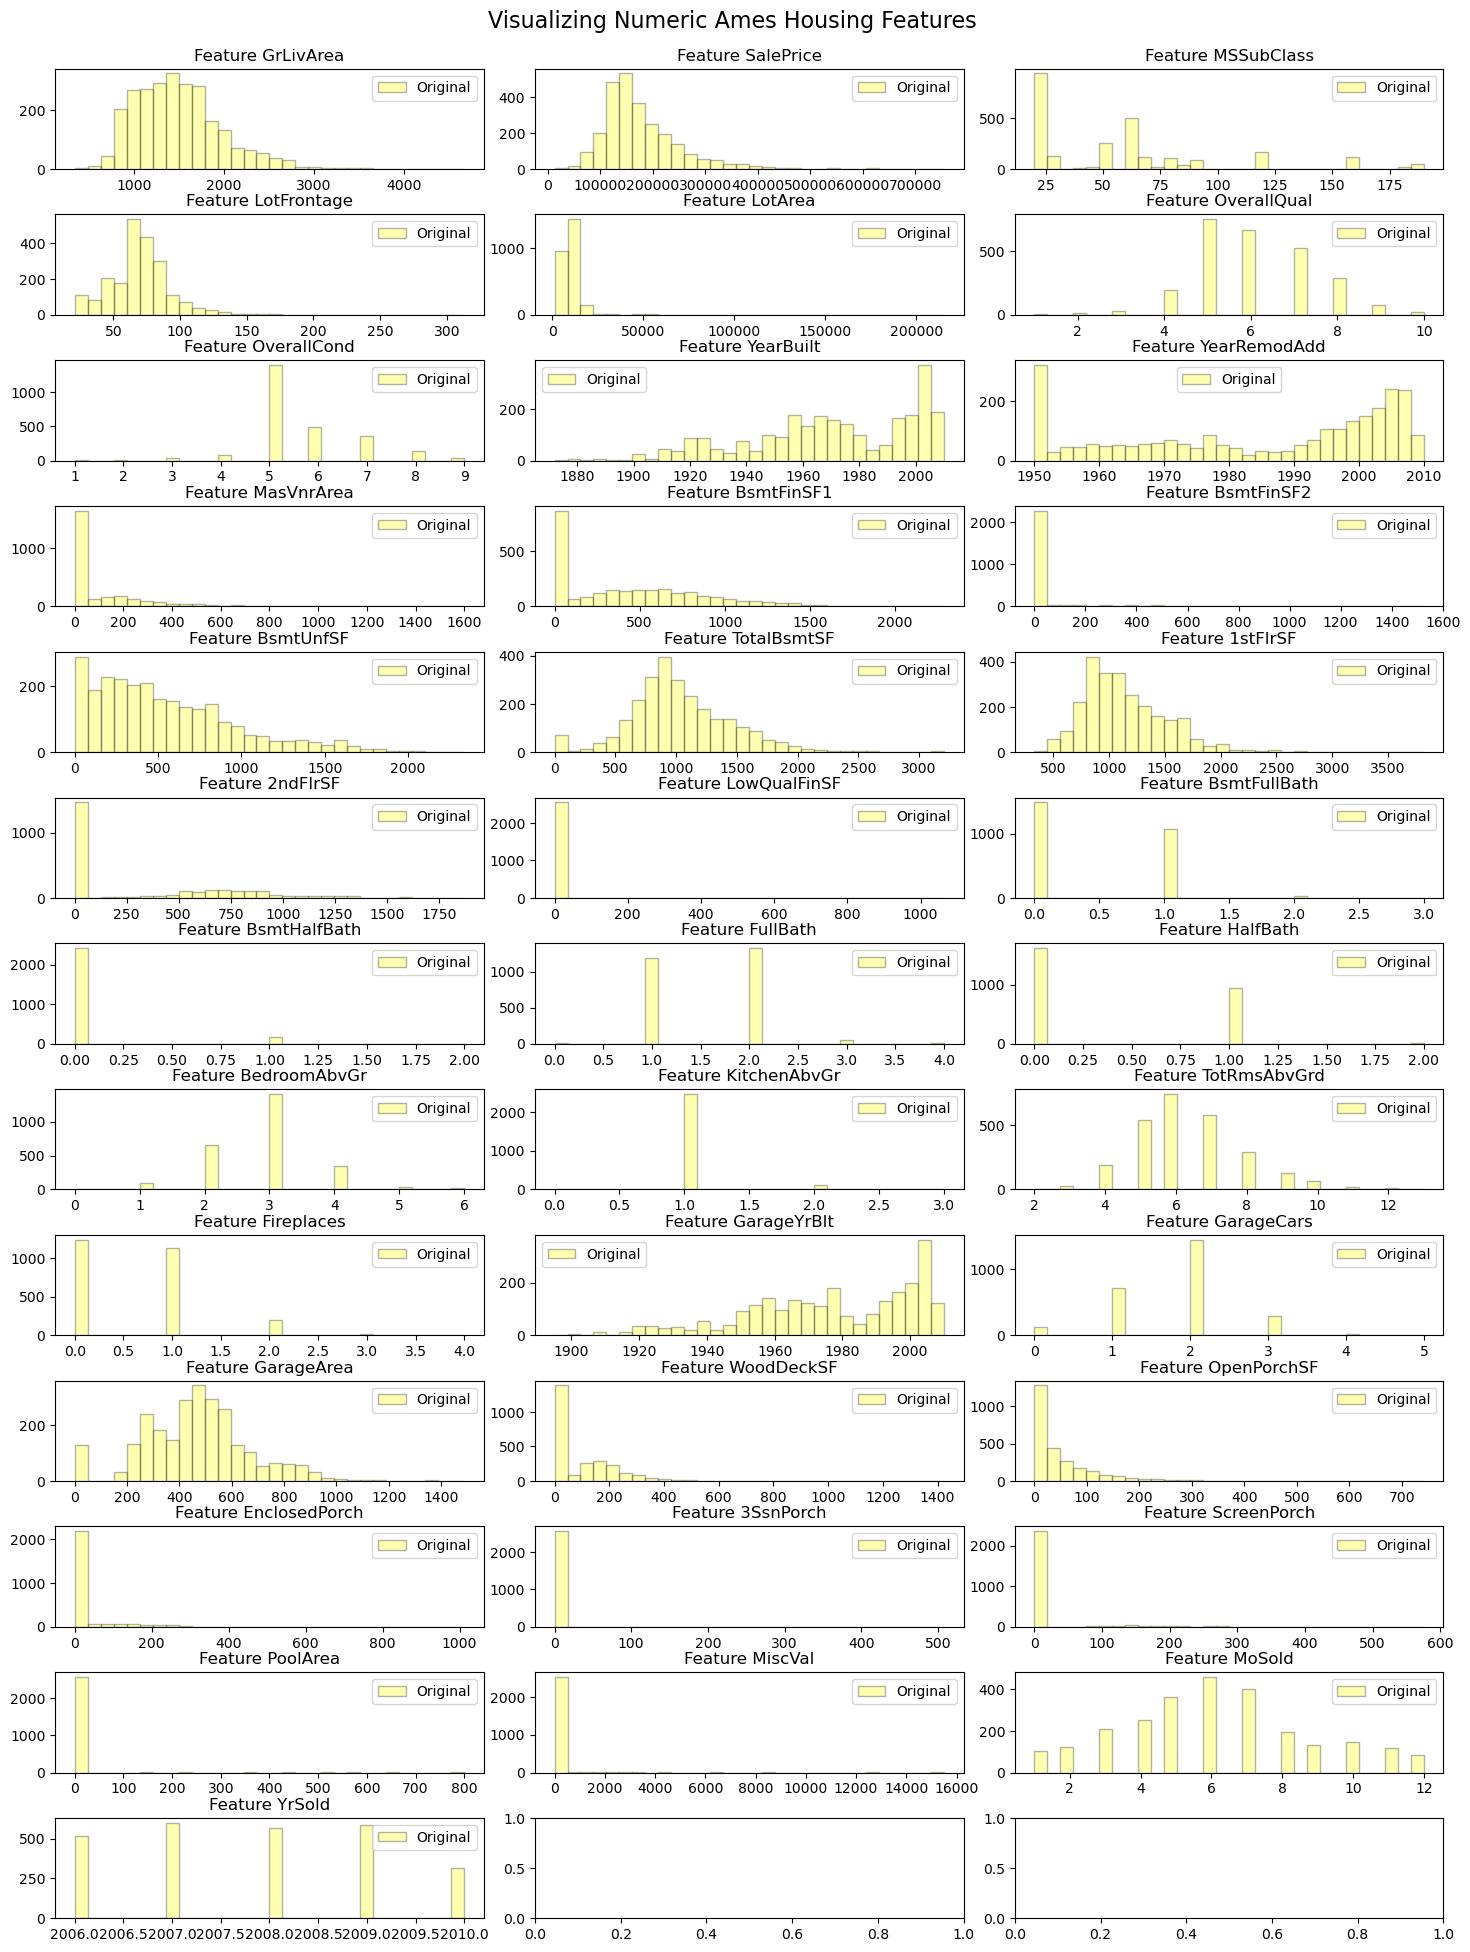

In [17]:
# visualize the features
import matplotlib.pyplot as plt
import numpy as np

num_features = numeric_features.shape[1] 
num_rows = 3  # Arrange subplots in a grid
num_cols = 13

fig, axes = plt.subplots(num_cols, num_rows, figsize=(15, 20))  # Create subplots
fig.suptitle("Visualizing Numeric Ames Housing Features", fontsize=16)

# Flatten axes for easy iteration
axes = axes.flatten()

col_name = list(numeric_features.columns)

for i in range(num_features):
    axes[i].hist(numeric_features.iloc[:, i], bins=30, alpha=0.3, color='yellow', edgecolor='black', label='Original')
    axes[i].set_title(f'Feature {col_name[i]}')  # Set title based on column names
    axes[i].legend()  # Add legend to differentiate the two distributions

plt.tight_layout(pad=2, h_pad=.1, w_pad=.1)  # Adjust layout
plt.show()

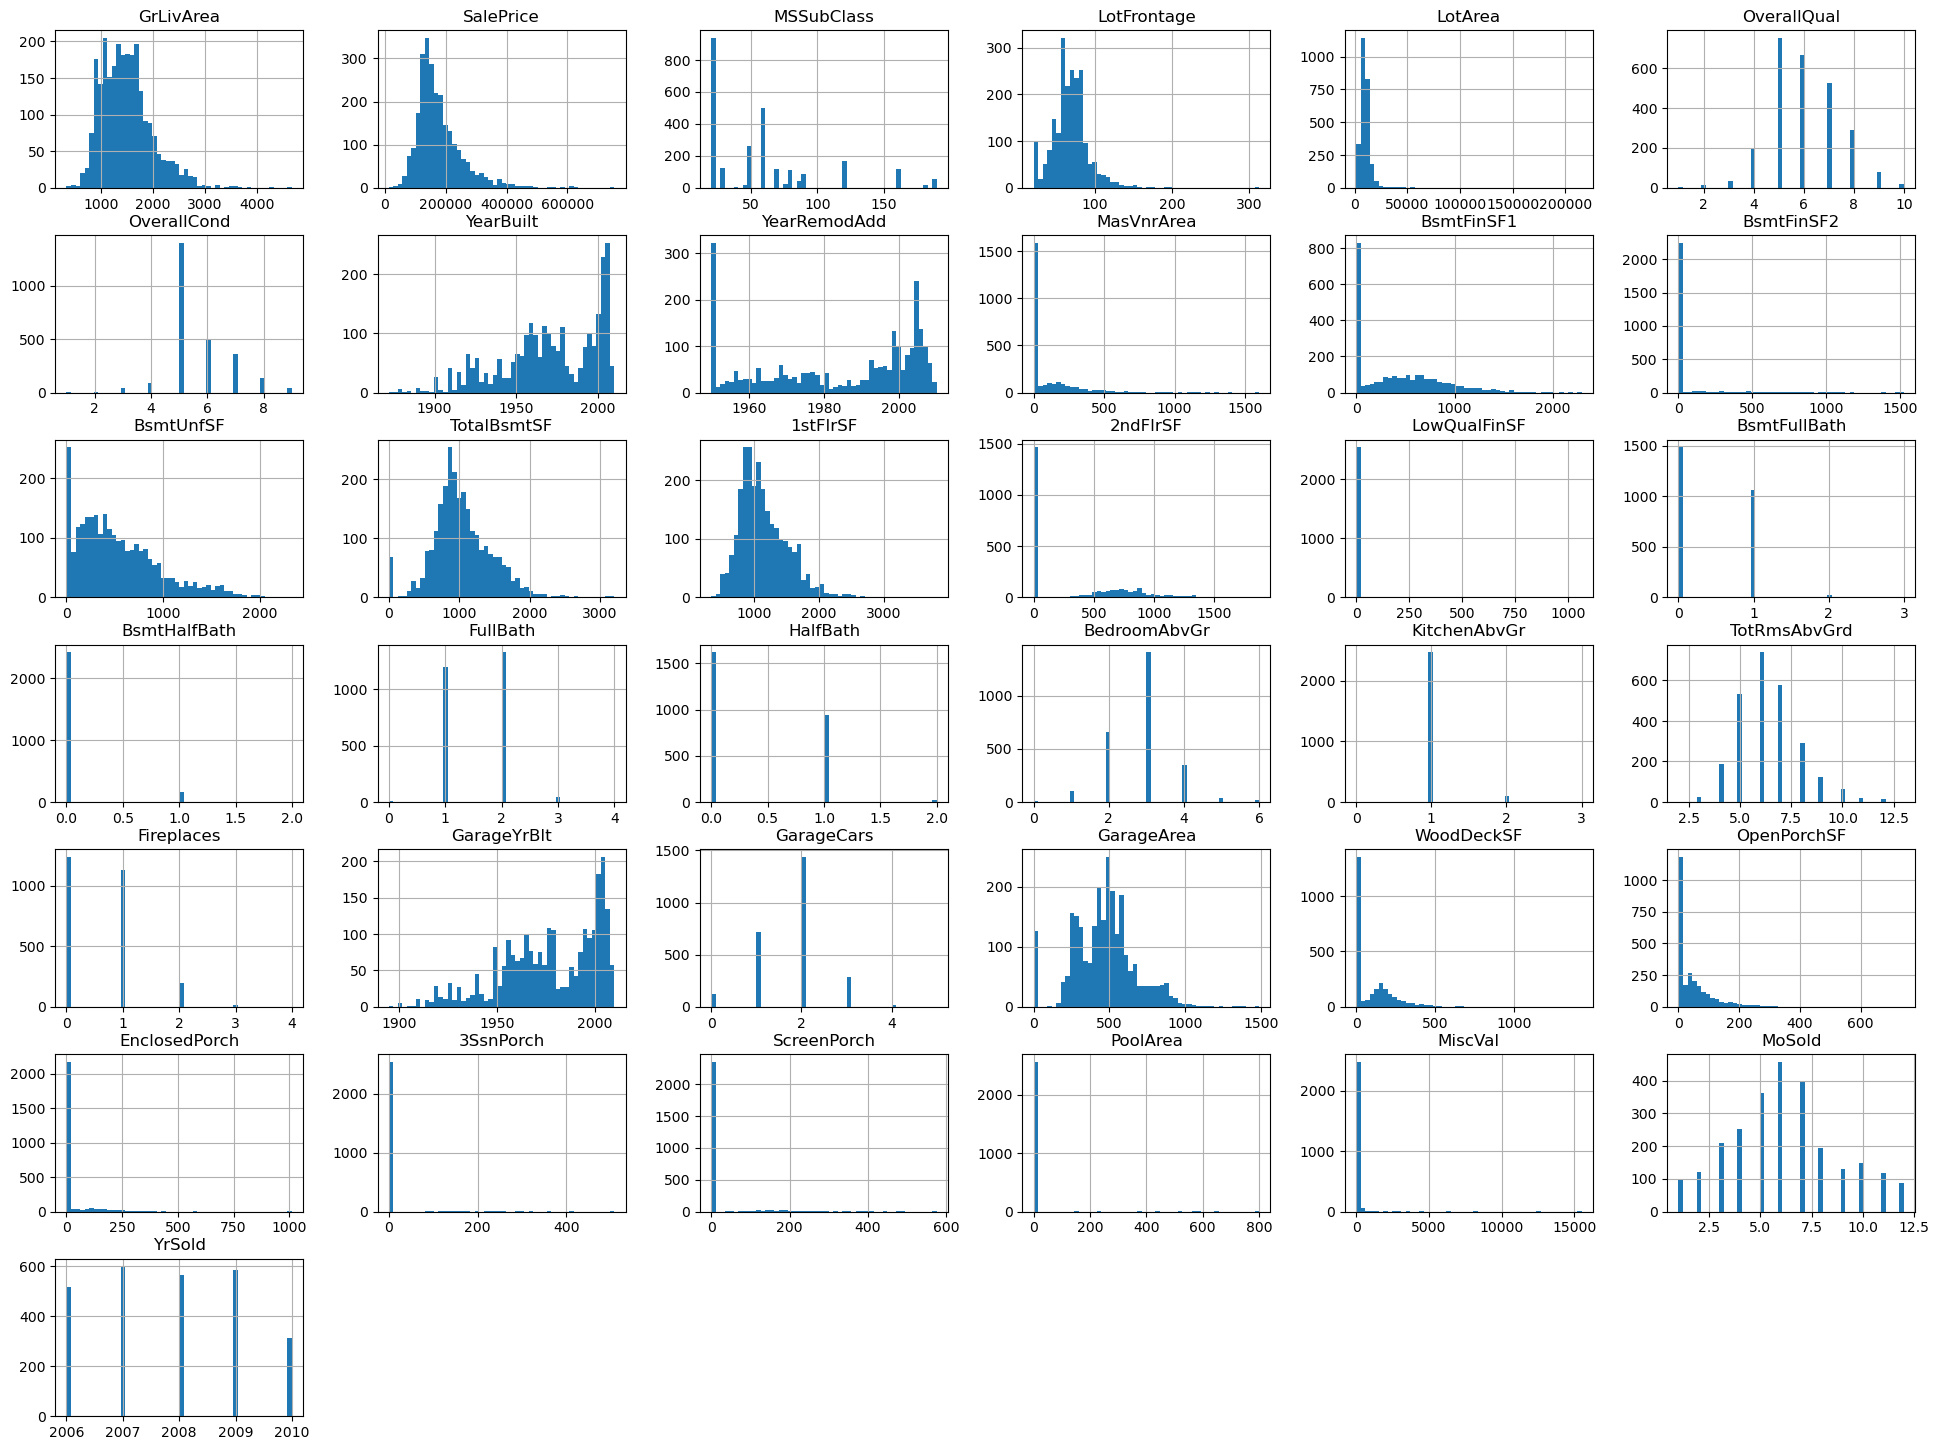

In [18]:
# (run on imputed ames data)
ames.hist(bins=50, figsize=(24,18));

In [19]:
ames.EnclosedPorch.value_counts()

EnclosedPorch
0      2170
112      18
144      11
96       10
192       9
       ... 
162       1
91        1
318       1
161       1
259       1
Name: count, Length: 170, dtype: int64

# Data Types

GarageYrBuilt and YearBuilt --> same data types
- these feature are highly correlated and should be treated similarly
    
[Return To Top](#Contents)

# Outlier Analysis

[Return To Top](#Contents)

# Missing Data
all features

[Return To Top](#Contents)

(See Vinod's post: https://machinelearningmastery.com/revealing_the_invisible/)

In [23]:
# visulazing missing data (see Vinod's post)
missing_data = ames.isnull().sum()
missing_data

GrLivArea          0
SalePrice          0
MSSubClass         0
MSZoning           0
LotFrontage      462
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
Length: 80, dtype: int64

In [24]:
missing_data[missing_data != 0]

LotFrontage      462
Alley           2412
MasVnrType      1573
MasVnrArea        14
BsmtQual          69
BsmtCond          69
BsmtExposure      71
BsmtFinType1      69
BsmtFinSF1         1
BsmtFinType2      70
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
FireplaceQu     1241
GarageType       127
GarageYrBlt      129
GarageFinish     129
GarageCars         1
GarageArea         1
GarageQual       129
GarageCond       129
PoolQC          2571
Fence           2055
MiscFeature     2483
dtype: int64

In [25]:
# calculate percentage of data missing for each feature
# len(ames) = number of rows
missing_percentage = (missing_data / len(ames)) * 100
missing_percentage.head()

GrLivArea       0.000000
SalePrice       0.000000
MSSubClass      0.000000
MSZoning        0.000000
LotFrontage    17.906977
dtype: float64

In [26]:
missing_percentage[missing_percentage != 0]

LotFrontage     17.906977
Alley           93.488372
MasVnrType      60.968992
MasVnrArea       0.542636
BsmtQual         2.674419
BsmtCond         2.674419
BsmtExposure     2.751938
BsmtFinType1     2.674419
BsmtFinSF1       0.038760
BsmtFinType2     2.713178
BsmtFinSF2       0.038760
BsmtUnfSF        0.038760
TotalBsmtSF      0.038760
Electrical       0.038760
BsmtFullBath     0.077519
BsmtHalfBath     0.077519
FireplaceQu     48.100775
GarageType       4.922481
GarageYrBlt      5.000000
GarageFinish     5.000000
GarageCars       0.038760
GarageArea       0.038760
GarageQual       5.000000
GarageCond       5.000000
PoolQC          99.651163
Fence           79.651163
MiscFeature     96.240310
dtype: float64

In [27]:
# collect data types for each feature
data_type = ames.dtypes
data_type

GrLivArea          int64
SalePrice          int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 80, dtype: object

In [28]:
# turn into a df
data = {'Missing Values': missing_data,
        'Percentage': missing_percentage,
        'Data Type': data_type}
missing_info = pd.DataFrame(data)
missing_info[missing_info['Missing Values'] != 0]

Missing Values  Percentage Data Type
LotFrontage              462   17.906977   float64
Alley                   2412   93.488372    object
MasVnrType              1573   60.968992    object
MasVnrArea                14    0.542636   float64
BsmtQual                  69    2.674419    object
BsmtCond                  69    2.674419    object
BsmtExposure              71    2.751938    object
BsmtFinType1              69    2.674419    object
BsmtFinSF1                 1    0.038760   float64
BsmtFinType2              70    2.713178    object
BsmtFinSF2                 1    0.038760   float64
BsmtUnfSF                  1    0.038760   float64
TotalBsmtSF                1    0.038760   float64
Electrical                 1    0.038760    object
BsmtFullBath               2    0.077519   float64
BsmtHalfBath               2    0.077519   float64
FireplaceQu             1241   48.100775    object
GarageType               127    4.922481    object
GarageYrBlt              129    5.000000   float64
GarageFinish             129    5.000000    object
GarageCars                 1    0.038760   float64
GarageArea                 1    0.038760   float64
GarageQual               129    5.000000    object
GarageCond               129    5.000000    object
PoolQC                  2571   99.651163    object
Fence                   2055   79.651163    object
MiscFeature             2483   96.240310    object

In [29]:
missing_info = missing_info.sort_values(by='Percentage', ascending=False)
missing_info.head(30)

Missing Values  Percentage Data Type
PoolQC                  2571   99.651163    object
MiscFeature             2483   96.240310    object
Alley                   2412   93.488372    object
Fence                   2055   79.651163    object
MasVnrType              1573   60.968992    object
FireplaceQu             1241   48.100775    object
LotFrontage              462   17.906977   float64
GarageQual               129    5.000000    object
GarageFinish             129    5.000000    object
GarageYrBlt              129    5.000000   float64
GarageCond               129    5.000000    object
GarageType               127    4.922481    object
BsmtExposure              71    2.751938    object
BsmtFinType2              70    2.713178    object
BsmtCond                  69    2.674419    object
BsmtQual                  69    2.674419    object
BsmtFinType1              69    2.674419    object
MasVnrArea                14    0.542636   float64
BsmtFullBath               2    0.077519   float64
BsmtHalfBath               2    0.077519   float64
GarageArea                 1    0.038760   float64
Electrical                 1    0.038760    object
TotalBsmtSF                1    0.038760   float64
BsmtUnfSF                  1    0.038760   float64
BsmtFinSF2                 1    0.038760   float64
BsmtFinSF1                 1    0.038760   float64
GarageCars                 1    0.038760   float64
YrSold                     0    0.000000     int64
FullBath                   0    0.000000     int64
HalfBath                   0    0.000000     int64

In [30]:
missing_info[(missing_info['Missing Values'] > 0)]

Missing Values  Percentage Data Type
PoolQC                  2571   99.651163    object
MiscFeature             2483   96.240310    object
Alley                   2412   93.488372    object
Fence                   2055   79.651163    object
MasVnrType              1573   60.968992    object
FireplaceQu             1241   48.100775    object
LotFrontage              462   17.906977   float64
GarageQual               129    5.000000    object
GarageFinish             129    5.000000    object
GarageYrBlt              129    5.000000   float64
GarageCond               129    5.000000    object
GarageType               127    4.922481    object
BsmtExposure              71    2.751938    object
BsmtFinType2              70    2.713178    object
BsmtCond                  69    2.674419    object
BsmtQual                  69    2.674419    object
BsmtFinType1              69    2.674419    object
MasVnrArea                14    0.542636   float64
BsmtFullBath               2    0.077519   float64
BsmtHalfBath               2    0.077519   float64
GarageArea                 1    0.038760   float64
Electrical                 1    0.038760    object
TotalBsmtSF                1    0.038760   float64
BsmtUnfSF                  1    0.038760   float64
BsmtFinSF2                 1    0.038760   float64
BsmtFinSF1                 1    0.038760   float64
GarageCars                 1    0.038760   float64

In [31]:
missing_info['Data Type'] == np.number

PoolQC           False
MiscFeature      False
Alley            False
Fence            False
MasVnrType       False
                 ...  
SalePrice        False
HeatingQC        False
CentralAir       False
1stFlrSF         False
SaleCondition    False
Name: Data Type, Length: 80, dtype: bool

In [32]:
np.number

numpy.number

In [33]:
# list only the numerical features with missing data
print(missing_info[(missing_info['Missing Values'] > 0) 
      & (missing_info['Data Type'] == np.number)])

              Missing Values  Percentage Data Type
LotFrontage              462   17.906977   float64
GarageYrBlt              129    5.000000   float64
MasVnrArea                14    0.542636   float64
BsmtFullBath               2    0.077519   float64
BsmtHalfBath               2    0.077519   float64
GarageArea                 1    0.038760   float64
TotalBsmtSF                1    0.038760   float64
BsmtUnfSF                  1    0.038760   float64
BsmtFinSF2                 1    0.038760   float64
BsmtFinSF1                 1    0.038760   float64
GarageCars                 1    0.038760   float64


In [34]:
missing_info[(missing_info['Missing Values'] == 0)]

Missing Values  Percentage Data Type
YrSold                      0         0.0     int64
FullBath                    0         0.0     int64
HalfBath                    0         0.0     int64
BedroomAbvGr                0         0.0     int64
KitchenAbvGr                0         0.0     int64
KitchenQual                 0         0.0    object
SaleType                    0         0.0    object
MoSold                      0         0.0     int64
MiscVal                     0         0.0     int64
PoolArea                    0         0.0     int64
TotRmsAbvGrd                0         0.0     int64
Functional                  0         0.0    object
Fireplaces                  0         0.0     int64
ScreenPorch                 0         0.0     int64
3SsnPorch                   0         0.0     int64
EnclosedPorch               0         0.0     int64
OpenPorchSF                 0         0.0     int64
WoodDeckSF                  0         0.0     int64
PavedDrive                  0         0.0    object
GrLivArea                   0         0.0     int64
Heating                     0         0.0    object
LowQualFinSF                0         0.0     int64
2ndFlrSF                    0         0.0     int64
MSSubClass                  0         0.0     int64
MSZoning                    0         0.0    object
LotArea                     0         0.0     int64
Street                      0         0.0    object
LotShape                    0         0.0    object
LandContour                 0         0.0    object
Utilities                   0         0.0    object
LotConfig                   0         0.0    object
LandSlope                   0         0.0    object
Neighborhood                0         0.0    object
Condition1                  0         0.0    object
Condition2                  0         0.0    object
BldgType                    0         0.0    object
HouseStyle                  0         0.0    object
OverallQual                 0         0.0     int64
OverallCond                 0         0.0     int64
YearBuilt                   0         0.0     int64
YearRemodAdd                0         0.0     int64
RoofStyle                   0         0.0    object
RoofMatl                    0         0.0    object
Exterior1st                 0         0.0    object
Exterior2nd                 0         0.0    object
ExterQual                   0         0.0    object
ExterCond                   0         0.0    object
Foundation                  0         0.0    object
SalePrice                   0         0.0     int64
HeatingQC                   0         0.0    object
CentralAir                  0         0.0    object
1stFlrSF                    0         0.0     int64
SaleCondition               0         0.0    object

In [35]:
# list numerical features (Data Type = float64) with no missing data
print(missing_info[(missing_info['Missing Values'] == 0)
      & (missing_info['Data Type'] == np.number)])

Empty DataFrame
Columns: [Missing Values, Percentage, Data Type]
Index: []


#### ? other ways to select for data type

In [37]:
# type(missing_info[(missing_info['Missing Values'] == 0)])

In [38]:
# type(missing_info.select_dtypes(include='float'))

In [39]:
# list numerical features with no missing data
# print(missing_info[(missing_info['Missing Values'] == 0)
      # & (missing_info.select_dtypes(include='float'))])

In [40]:
#pip install missingno

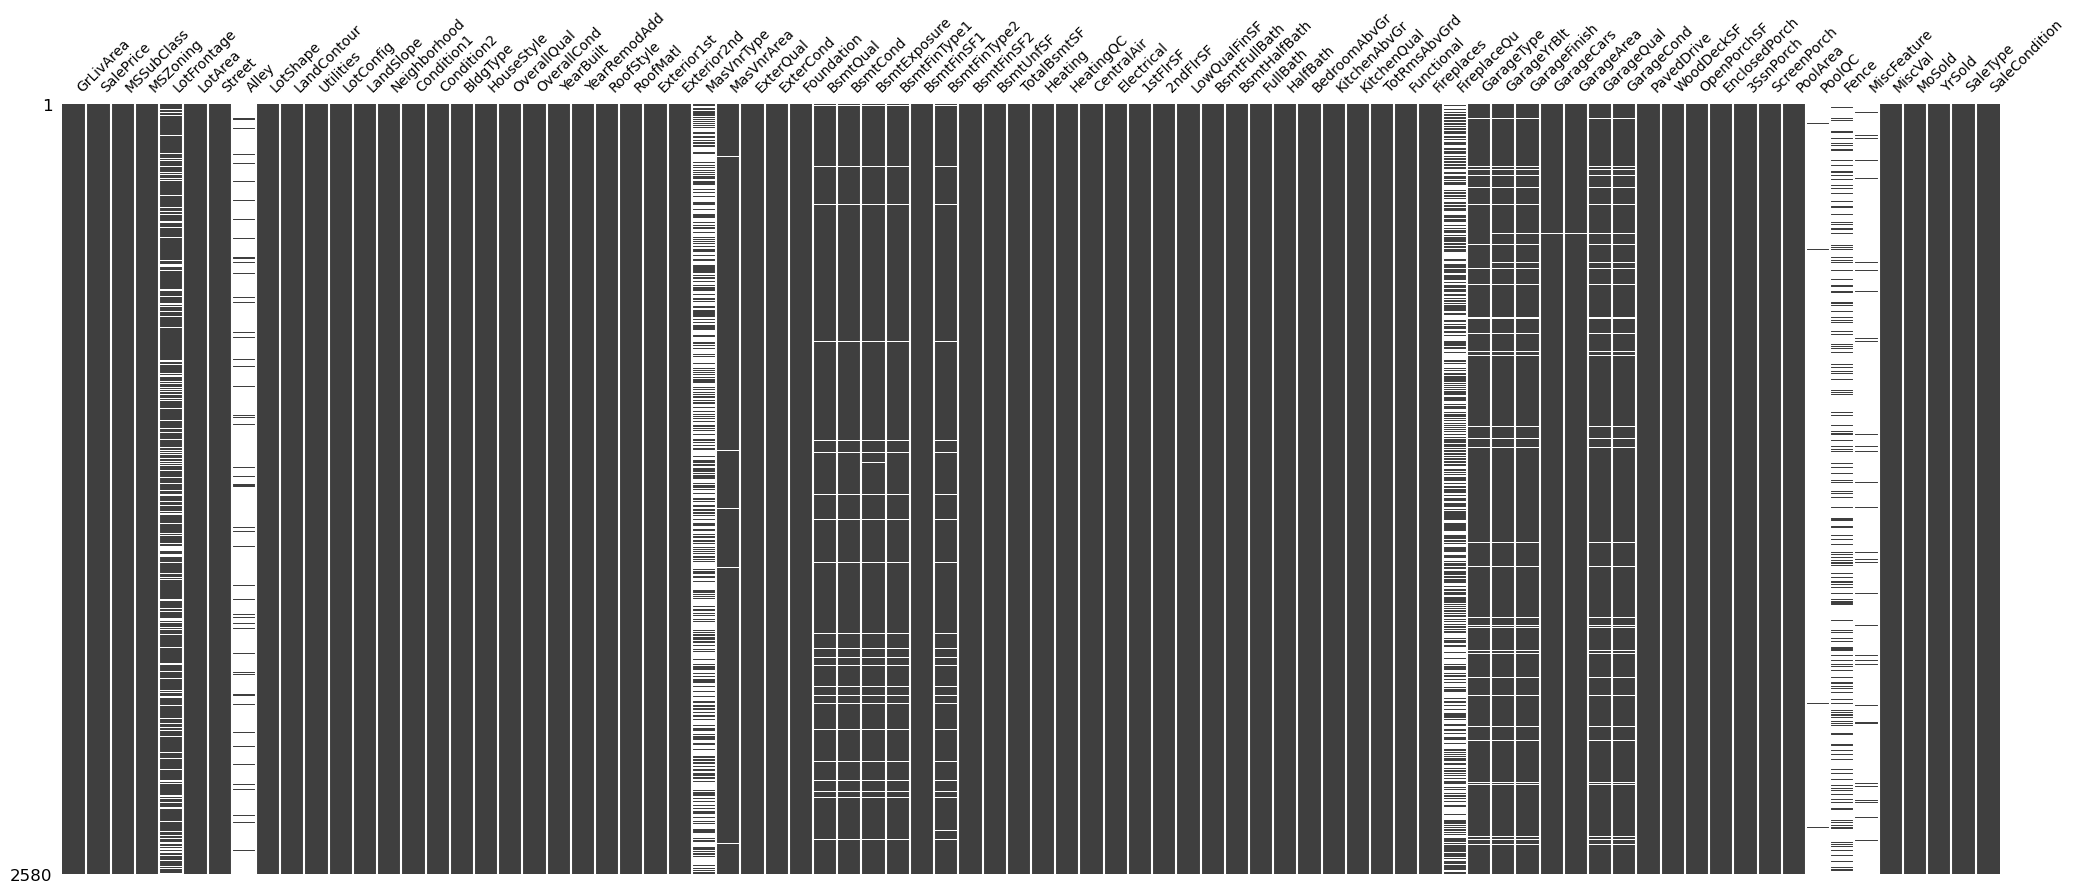

In [41]:
import missingno as msno
import matplotlib.pyplot as plt
msno.matrix(ames, sparkline=False, fontsize=10, labels=True)
plt.show()

In [42]:
# returns a list of features sorted by percentage, generated in missing_info
missing_info.sort_values(by='Percentage', ascending=False).index

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu',
       'LotFrontage', 'GarageQual', 'GarageFinish', 'GarageYrBlt',
       'GarageCond', 'GarageType', 'BsmtExposure', 'BsmtFinType2', 'BsmtCond',
       'BsmtQual', 'BsmtFinType1', 'MasVnrArea', 'BsmtFullBath',
       'BsmtHalfBath', 'BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GarageCars',
       'TotalBsmtSF', 'GarageArea', 'Electrical', 'YearBuilt', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'ExterQual', 'ExterCond', 'Foundation', 'SalePrice', 'HeatingQC',
       'CentralAir', '1stFlrSF', 'Street', 'LotShape', 'ScreenPorch',
       'LotArea', 'MSZoning', 'YrSold', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'SaleType', 'MoSold', 'MiscVal',
       'PoolArea', 'TotRmsAbv

In [43]:
# Sort the Ames DataFrame columns by the percentage of missing values
sorted_df = ames[missing_info.sort_values(by='Percentage', ascending=False).index]
sorted_df.head()

PoolQC MiscFeature Alley Fence MasVnrType FireplaceQu  LotFrontage  \
0    NaN         NaN   NaN   NaN        NaN          Gd          NaN   
1    NaN         NaN   NaN   NaN    BrkFace         NaN         42.0   
2    NaN         NaN   NaN   NaN        NaN         NaN         60.0   
3    NaN         NaN   NaN   NaN        NaN         NaN         80.0   
4    NaN         NaN   NaN   NaN        NaN         NaN         70.0   

  GarageQual GarageFinish  GarageYrBlt  ... EnclosedPorch OpenPorchSF  \
0         TA          Unf       1939.0  ...             0           0   
1         TA          Fin       1984.0  ...             0         105   
2         TA          Unf       1930.0  ...            42           0   
3         TA          Unf       1940.0  ...           168           0   
4         TA          Fin       2001.0  ...             0          45   

  WoodDeckSF PavedDrive GrLivArea Heating LowQualFinSF  2ndFlrSF  MSSubClass  \
0          0          Y       856    GasA            0         0          30   
1          0          Y      1049    GasA            0         0         120   
2        154          N      1001    GasA            0         0          30   
3          0          N      1039    GasA            0       322          70   
4          0          Y      1665    GasA            0       855          60   

   SaleCondition  
0         Normal  
1         Normal  
2         Normal  
3         Normal  
4         Normal  

[5 rows x 80 columns]

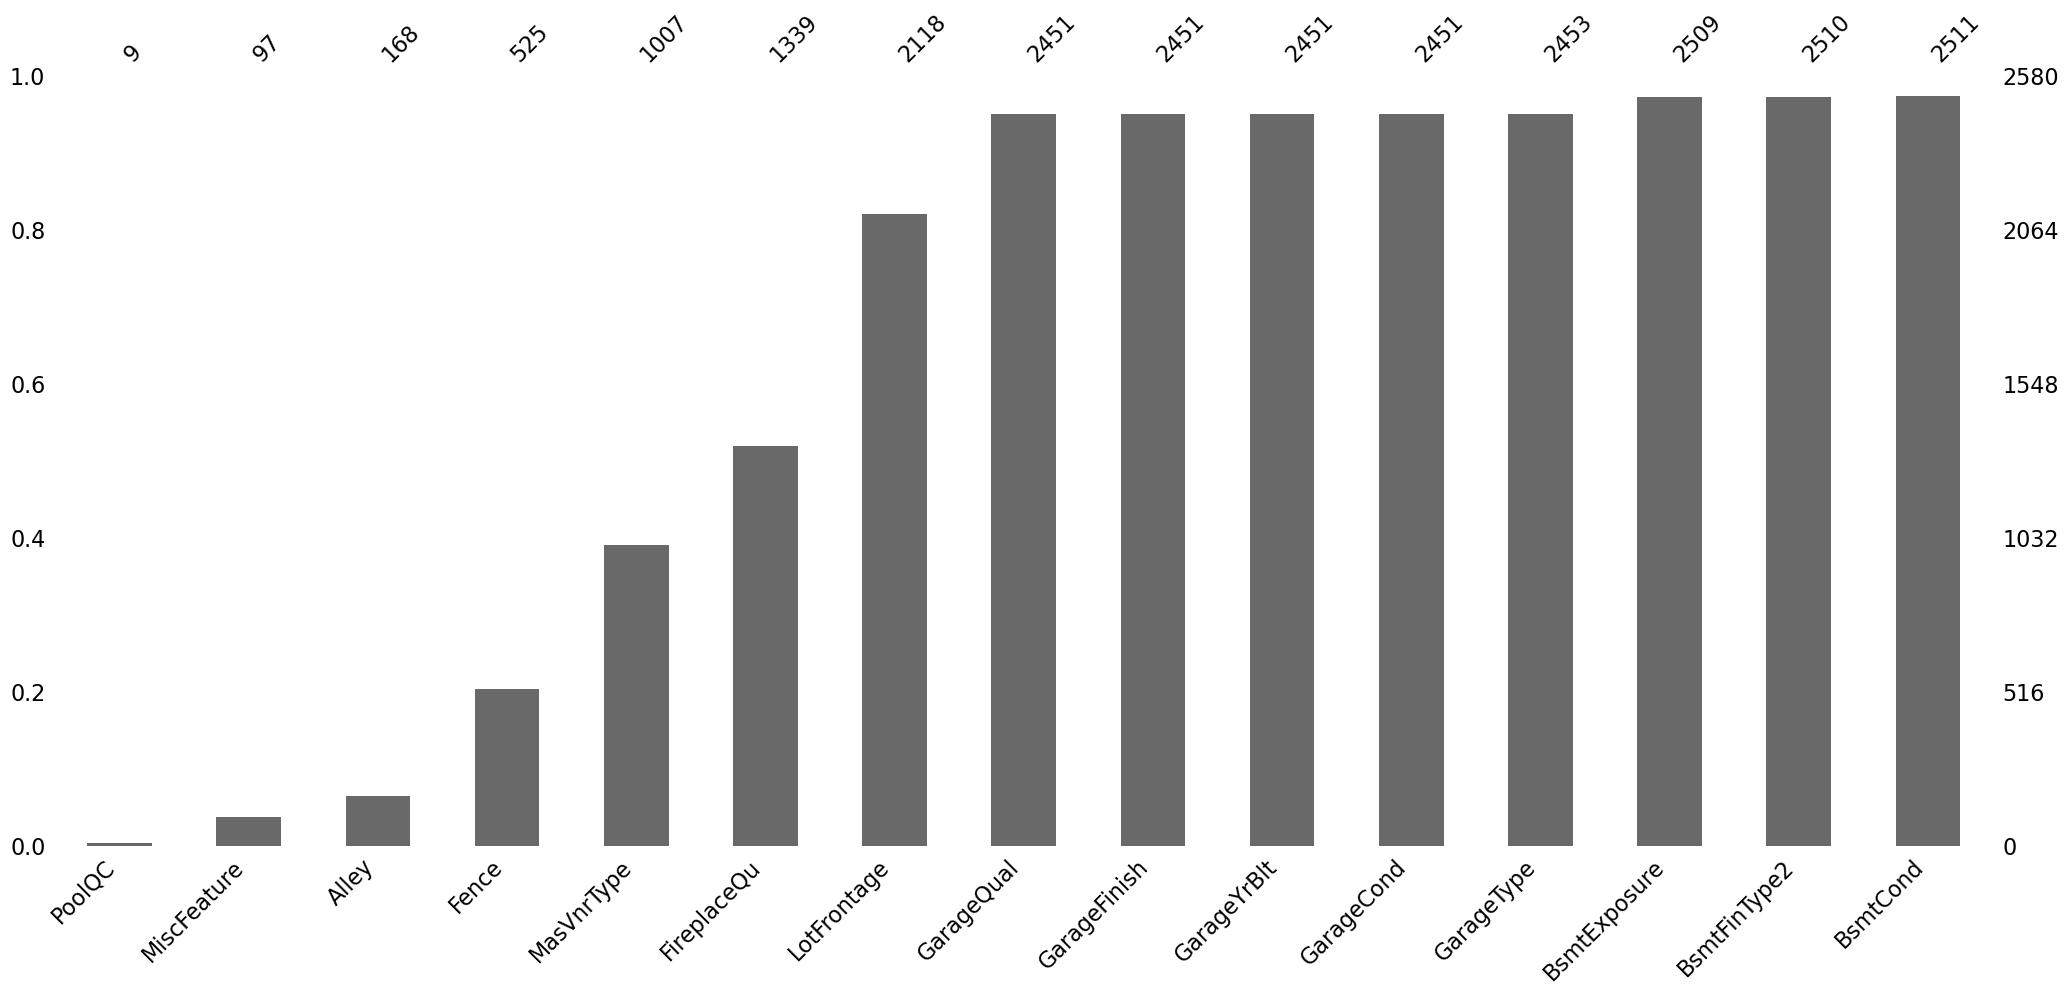

In [44]:
# Select the top 15 columns with the most missing values
top_15_missing = sorted_df.iloc[:, :15]

#Visual with missingno
msno.bar(top_15_missing)
plt.show()

In [45]:
# create a list of the 15 features with the highest amount of missing data
top_15_missing_info = missing_info.nlargest(15, 'Percentage')
top_15_missing_info.index

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu',
       'LotFrontage', 'GarageQual', 'GarageFinish', 'GarageYrBlt',
       'GarageCond', 'GarageType', 'BsmtExposure', 'BsmtFinType2', 'BsmtCond'],
      dtype='object')

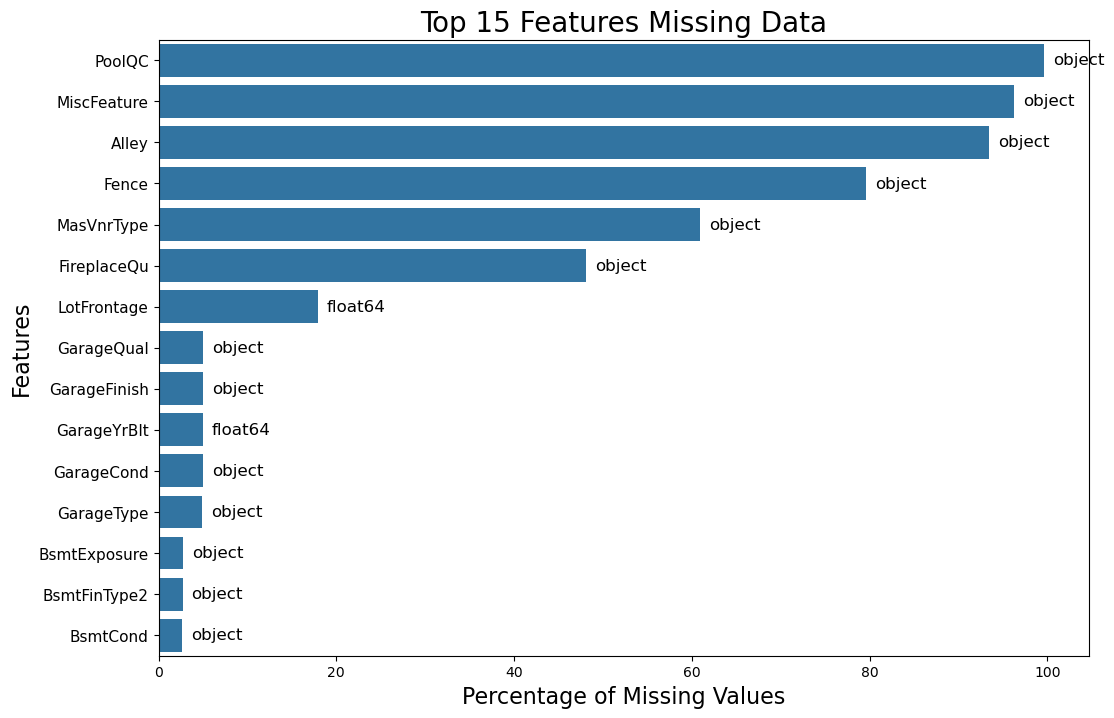

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
 
# Filter to show only the top 15 columns with the most missing values
top_15_missing_info = missing_info.nlargest(15, 'Percentage')
 
# Create the horizontal bar plot using seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='Percentage', y=top_15_missing_info.index, data=top_15_missing_info, orient='h')

# Add data type annotations
for index, (percentage, feature) in enumerate(zip(top_15_missing_info['Percentage'], top_15_missing_info.index)):
    dtype = top_15_missing_info.loc[feature, 'Data Type']  # Extract dtype
    plt.text(percentage + 1, index, str(dtype), va='center', fontsize=12, color='black')

plt.title('Top 15 Features Missing Data', fontsize=20)
plt.xlabel('Percentage of Missing Values', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.yticks(fontsize=11)
plt.show()

# Data Imputation
[Return To Top](#Contents)

In [48]:
# import pandas as pd
# import numpy as np

In [49]:
# from above: return a list of features sorted by percentage, generated in missing_info
missing_info.sort_values(by='Percentage', ascending=False).index

#list only the numerical features with missing data
print(missing_info[(missing_info['Missing Values'] > 0) 
      & (missing_info['Data Type'] == np.number)])

              Missing Values  Percentage Data Type
LotFrontage              462   17.906977   float64
GarageYrBlt              129    5.000000   float64
MasVnrArea                14    0.542636   float64
BsmtFullBath               2    0.077519   float64
BsmtHalfBath               2    0.077519   float64
GarageArea                 1    0.038760   float64
TotalBsmtSF                1    0.038760   float64
BsmtUnfSF                  1    0.038760   float64
BsmtFinSF2                 1    0.038760   float64
BsmtFinSF1                 1    0.038760   float64
GarageCars                 1    0.038760   float64


Imputation method:

LotFrontage 
- 18% missing
- skewed; median more robust than mean
- imputed with median
  

GarageYrBlt 
- 5% missing
- GarageYrBlt and YearBuilt are highly correlated
- Of the observations with no missing GarageYrBlt values, only 488 of them are not the same. That is, roughly 80% match.
- Impute missing GarageYrBlt values with their corresponding YearBuilt values. 


Less than 1% missing - continuous values (use median for imputation): 

- MasVnrArea             
- BsmtFullBath          
- BsmtHalfBath            
- GarageArea             
- TotalBsmtSF              
- BsmtUnfSF                  
- BsmtFinSF2                
- BsmtFinSF1


Less than 1% missing - discrete values (impute with discrete values)
- GarageCars
- BsmtFullBath          
- BsmtHalfBath

### LotFrontage

In [52]:
lot_data = ames[['LotFrontage', 'LotArea']]
lot_data

LotFrontage  LotArea
0             NaN     7890
1            42.0     4235
2            60.0     6060
3            80.0     8146
4            70.0     8400
...           ...      ...
2575          NaN     8854
2576          NaN    13680
2577         82.0     6270
2578          NaN     8826
2579         80.0     9554

[2580 rows x 2 columns]

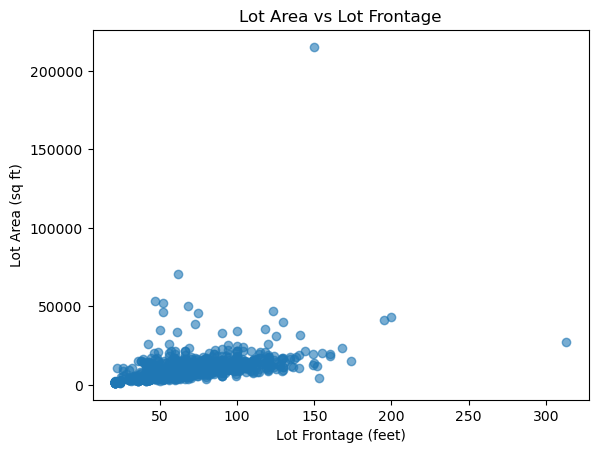

In [53]:
plt.scatter(lot_data['LotFrontage'], lot_data['LotArea'], alpha=0.6)
plt.xlabel('Lot Frontage (feet)')
plt.ylabel('Lot Area (sq ft)')
plt.title('Lot Area vs Lot Frontage')
plt.show()

In [54]:
lot_data['LotFrontage'].corr(lot_data['LotArea'])

0.46372011530445967

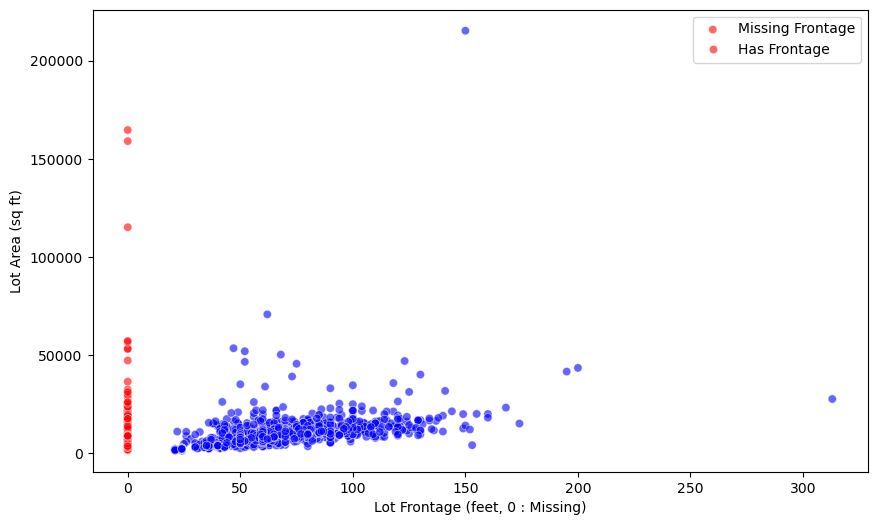

In [55]:
import seaborn as sns

# Create a new column indicating missing status
lot_plot = lot_data.copy()
lot_plot['has_frontage'] = ~lot_plot['LotFrontage'].isna()
lot_plot['no_frontage'] = lot_plot['LotFrontage'].fillna(0)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=lot_plot, 
                x='no_frontage', y='LotArea',
                hue='has_frontage', 
                palette={True: 'blue', False: 'red'},
                alpha=0.6)
plt.xlabel('Lot Frontage (feet, 0 : Missing)')
plt.ylabel('Lot Area (sq ft)')
plt.legend(labels=['Missing Frontage', 'Has Frontage'])
plt.show()

In [56]:
lot_data[lot_data['LotArea'] > 100000]

LotFrontage  LotArea
249           NaN   159000
355         150.0   215245
1271          NaN   115149
1634          NaN   164660

In [57]:
lot_data.describe()

LotFrontage        LotArea
count  2118.000000    2580.000000
mean     68.516053   10120.153488
std      22.835831    8126.937892
min      21.000000    1300.000000
25%      57.000000    7406.750000
50%      68.000000    9391.000000
75%      80.000000   11494.000000
max     313.000000  215245.000000

In [58]:
lot_data_no_missing = lot_data.dropna()
lot_data_no_missing

LotFrontage  LotArea
1            42.0     4235
2            60.0     6060
3            80.0     8146
4            70.0     8400
5            64.0     7301
...           ...      ...
2572         84.0    17808
2573         60.0     8550
2574         62.0     7162
2577         82.0     6270
2579         80.0     9554

[2118 rows x 2 columns]

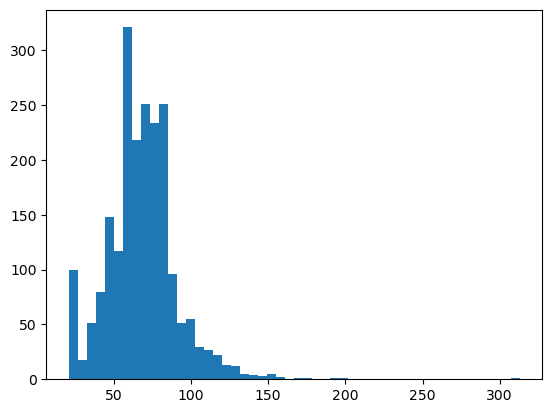

In [59]:
plt.hist(ames[['LotFrontage']], bins=50)
plt.show()

### GarageYrBlt

In [61]:
ames[['GarageYrBlt', 'YearBuilt']].corr()

GarageYrBlt  YearBuilt
GarageYrBlt     1.000000   0.834526
YearBuilt       0.834526   1.000000

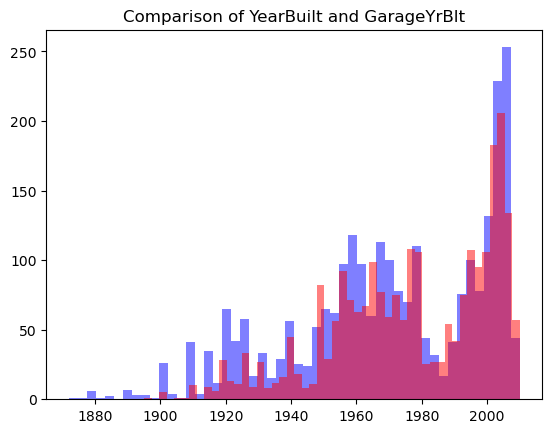

In [62]:
plt.hist(ames[['YearBuilt']], bins=50, alpha=0.5, color='blue')
plt.hist(ames[['GarageYrBlt']], bins=50, alpha=0.5, color='red')
plt.title("Comparison of YearBuilt and GarageYrBlt")
plt.show()

In [63]:
ames[['GarageYrBlt', 'YearBuilt']]

GarageYrBlt  YearBuilt
0          1939.0       1939
1          1984.0       1984
2          1930.0       1930
3          1940.0       1900
4          2001.0       2001
...           ...        ...
2575       1916.0       1916
2576       1955.0       1955
2577       1949.0       1949
2578       2000.0       2000
2579       1993.0       1993

[2580 rows x 2 columns]

In [64]:
ames[['GarageYrBlt', 'YearBuilt']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   GarageYrBlt  2451 non-null   float64
 1   YearBuilt    2580 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 40.4 KB


In [65]:
yr_blt_no_nulls = ames[['GarageYrBlt', 'YearBuilt']].dropna()
yr_blt_no_nulls

GarageYrBlt  YearBuilt
0          1939.0       1939
1          1984.0       1984
2          1930.0       1930
3          1940.0       1900
4          2001.0       2001
...           ...        ...
2575       1916.0       1916
2576       1955.0       1955
2577       1949.0       1949
2578       2000.0       2000
2579       1993.0       1993

[2451 rows x 2 columns]

In [66]:
yr_blt_no_nulls = yr_blt_no_nulls.astype({'GarageYrBlt': 'int64'})
yr_blt_no_nulls

GarageYrBlt  YearBuilt
0            1939       1939
1            1984       1984
2            1930       1930
3            1940       1900
4            2001       2001
...           ...        ...
2575         1916       1916
2576         1955       1955
2577         1949       1949
2578         2000       2000
2579         1993       1993

[2451 rows x 2 columns]

In [67]:
differences = yr_blt_no_nulls[yr_blt_no_nulls['GarageYrBlt'] != yr_blt_no_nulls['YearBuilt']]
differences

GarageYrBlt  YearBuilt
3            1940       1900
6            1974       1953
10           2007       2006
11           1993       1991
23           1950       1880
...           ...        ...
2552         1950       1917
2559         1956       1959
2567         1965       1940
2571         1970       1968
2573         1949       1934

[488 rows x 2 columns]

In [68]:
# Is there a relation with the remodel year? (YearRemodAdd is also highly correlated with GarageYrBlt)
differences_w_remodel = differences.join(ames[['YearRemodAdd']], how='left')
differences_w_remodel.head(30)

GarageYrBlt  YearBuilt  YearRemodAdd
3           1940       1900          2003
6           1974       1953          1953
10          2007       2006          2007
11          1993       1991          1991
23          1950       1880          2003
24          1997       1971          1971
25          2007       2006          2007
33          1922       1923          2000
34          1964       1960          1960
39          1974       1966          1966
43          1990       1963          1963
49          1966       1910          1981
68          1969       1919          1990
71          2007       2006          2007
75          2007       2006          2007
82          1970       1920          1950
83          1983       1982          1982
86          1979       1978          1978
87          1977       1920          1950
88          1965       1924          1950
92          2001       1926          1950
116         1996       1890          1998
119         1964       1957          1957
125         1962       1953          2006
126         1963       1958          2000
133         1977       1941          1960
136         1943       1924          1996
142         2005       1959          2005
147         1974       1967          1975
149         1994       1921          2005

# Less than 1% missing - continuous features: 

- MasVnrArea (14 missing values)                       
- GarageArea (1)            
- TotalBsmtSF (1)             
- BsmtUnfSF (1)                 
- BsmtFinSF2 (1)              
- BsmtFinSF1 (1)

In [70]:
ames[['MasVnrArea',                         
    'GarageArea',         
    'TotalBsmtSF',              
    'BsmtUnfSF',                  
    'BsmtFinSF2',                
    'BsmtFinSF1']].describe()

MasVnrArea   GarageArea  TotalBsmtSF    BsmtUnfSF   BsmtFinSF2  \
count  2566.000000  2579.000000  2579.000000  2579.000000  2579.000000   
mean     99.308262   466.842575  1036.686700   539.101590    53.238852   
std     175.872330   207.476842   418.555417   425.199639   174.423920   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000   318.000000   792.000000   215.000000     0.000000   
50%       0.000000   474.000000   979.000000   448.000000     0.000000   
75%     158.000000   576.000000  1266.500000   784.000000     0.000000   
max    1600.000000  1488.000000  3206.000000  2336.000000  1526.000000   

        BsmtFinSF1  
count  2579.000000  
mean    444.346258  
std     429.334957  
min       0.000000  
25%       0.000000  
50%     384.000000  
75%     732.000000  
max    2288.000000

In [71]:
ames[['MasVnrArea',                         
    'GarageArea',         
    'TotalBsmtSF',              
    'BsmtUnfSF',                  
    'BsmtFinSF2',                
    'BsmtFinSF1']].median()

MasVnrArea       0.0
GarageArea     474.0
TotalBsmtSF    979.0
BsmtUnfSF      448.0
BsmtFinSF2       0.0
BsmtFinSF1     384.0
dtype: float64

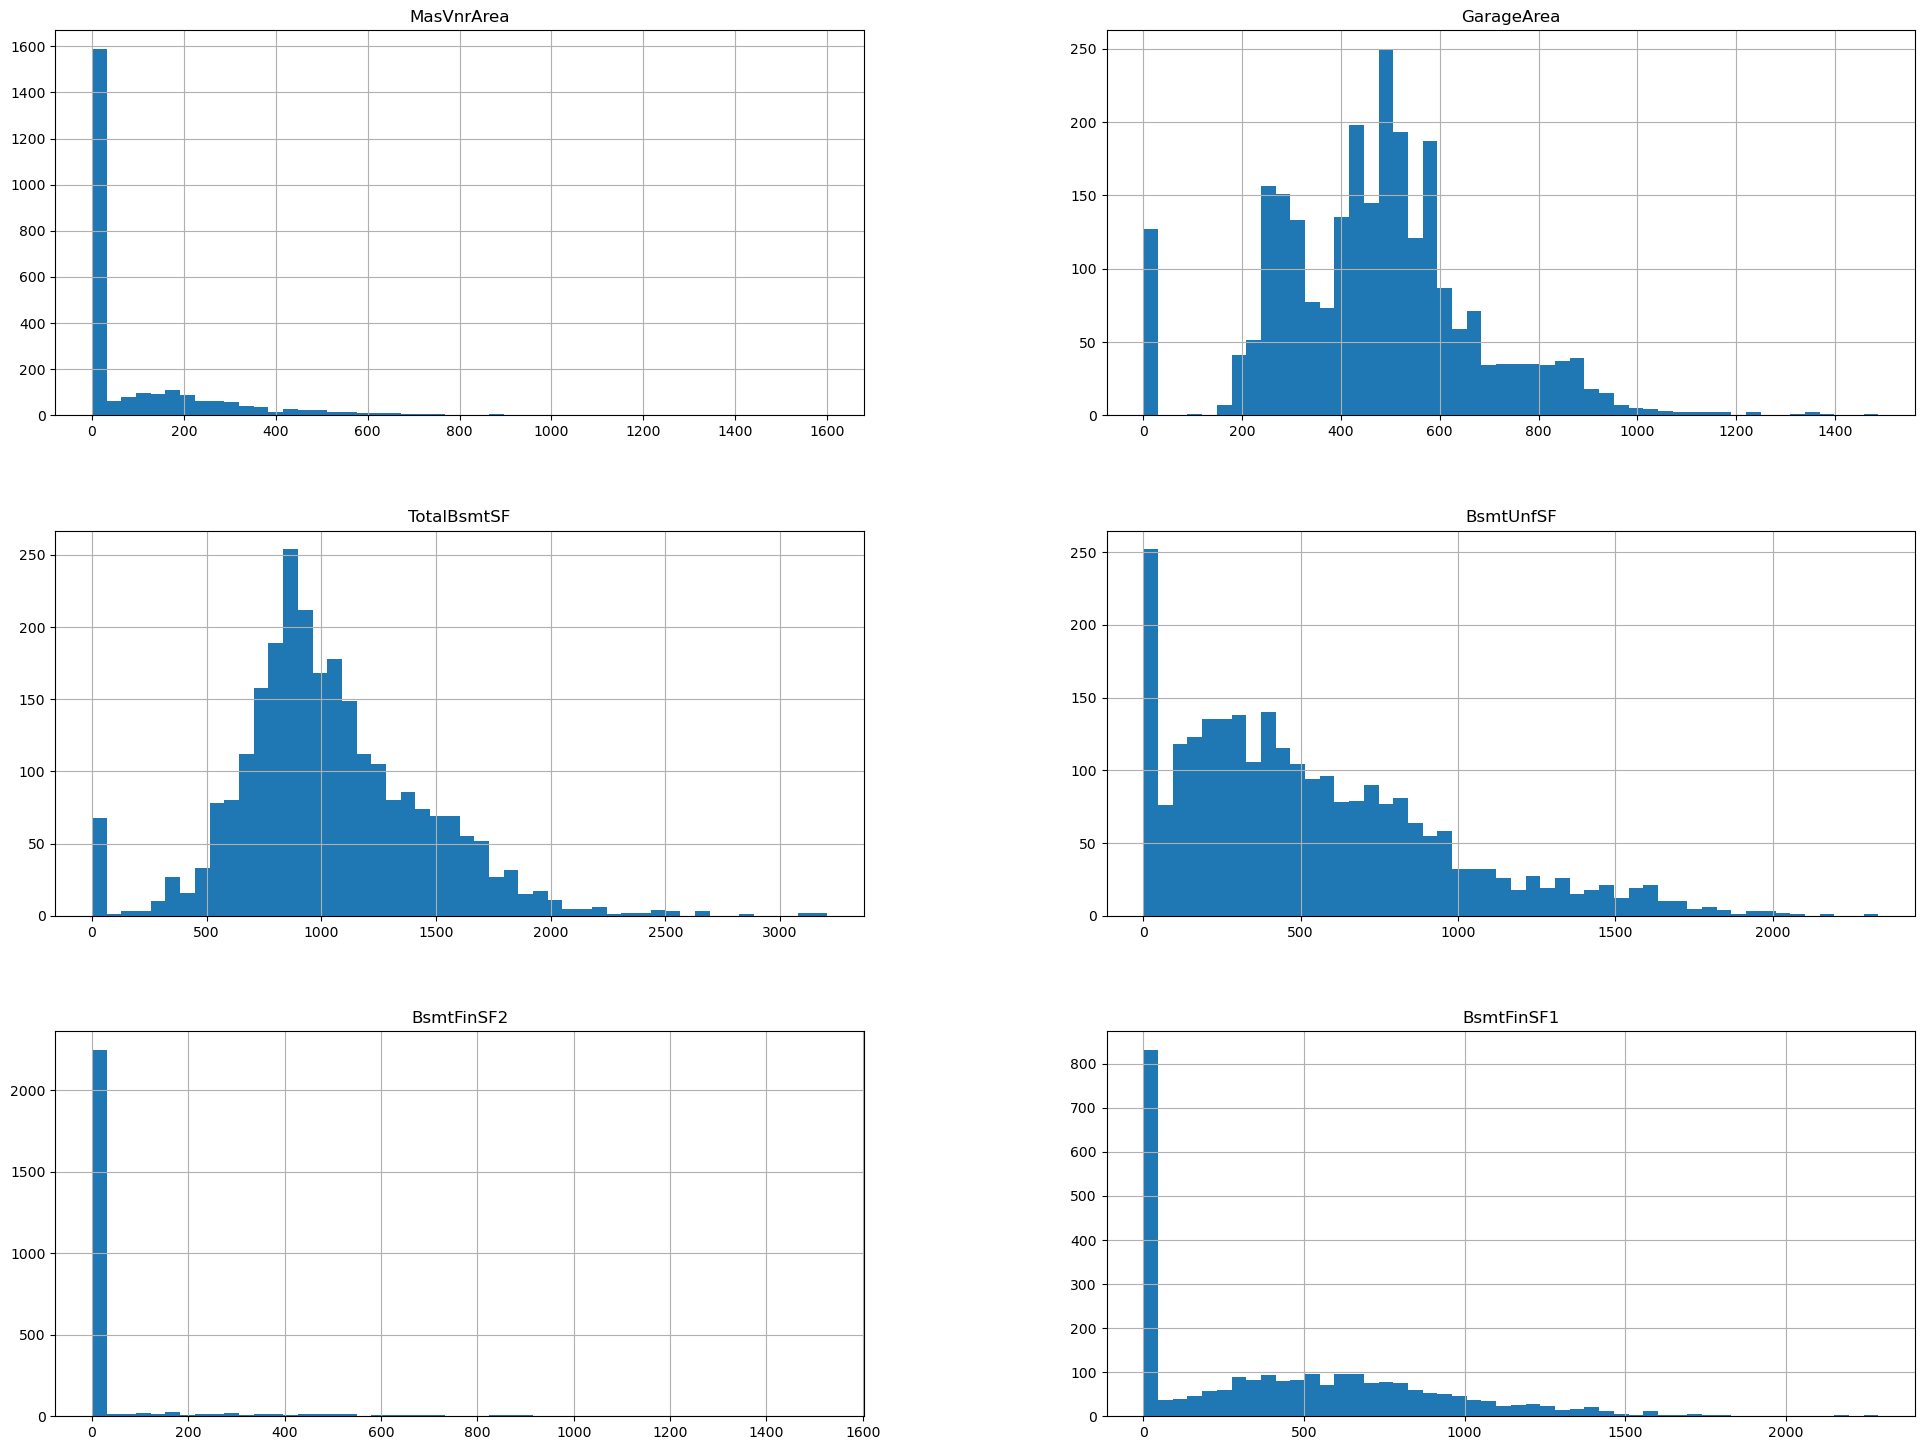

In [72]:
ames[['MasVnrArea',                         
    'GarageArea',         
    'TotalBsmtSF',              
    'BsmtUnfSF',                  
    'BsmtFinSF2',                
    'BsmtFinSF1']].hist(bins=50, figsize=(24,18));

# Less than 1% missing - discrete features: 

- BsmtFullBath (2 values missing)        
- BsmtHalfBath (2) 
- GarageCars (1)

In [74]:
ames[['BsmtFullBath', 'BsmtHalfBath', 'GarageCars']].describe()

BsmtFullBath  BsmtHalfBath   GarageCars
count   2578.000000   2578.000000  2579.000000
mean       0.435221      0.062064     1.747577
std        0.518827      0.244513     0.738678
min        0.000000      0.000000     0.000000
25%        0.000000      0.000000     1.000000
50%        0.000000      0.000000     2.000000
75%        1.000000      0.000000     2.000000
max        3.000000      2.000000     5.000000

In [75]:
ames[['BsmtFullBath', 'BsmtHalfBath', 'GarageCars']].mode()

BsmtFullBath  BsmtHalfBath  GarageCars
0           0.0           0.0         2.0

In [76]:
ames[ames['GarageCars'].isna()]

GrLivArea  SalePrice  MSSubClass MSZoning  LotFrontage  LotArea Street  \
433       1828     150909          70       RM         50.0     9060   Pave   

    Alley LotShape LandContour  ... ScreenPorch PoolArea PoolQC  Fence  \
433   NaN      Reg         Lvl  ...           0        0    NaN  MnPrv   

    MiscFeature MiscVal MoSold YrSold  SaleType  SaleCondition  
433         NaN       0      3   2007       WD          Alloca  

[1 rows x 80 columns]

In [77]:
ames.iloc[433][['SalePrice', 'GarageCars', 'GarageYrBlt', 'GarageArea', 'GarageFinish', 'GarageType']]

SalePrice       150909
GarageCars         NaN
GarageYrBlt        NaN
GarageArea         NaN
GarageFinish       NaN
GarageType      Detchd
Name: 433, dtype: object

In [78]:
ames['GarageType'].value_counts()

GarageType
Attchd     1527
Detchd      716
BuiltIn     153
Basment      27
2Types       21
CarPort       9
Name: count, dtype: int64

In [79]:
ames.groupby('GarageType')['SalePrice'].mean()

GarageType
2Types     154080.952381
Attchd     200661.569090
Basment    155150.000000
BuiltIn    233054.464052
CarPort    110716.666667
Detchd     133291.765363
Name: SalePrice, dtype: float64

#### Using mean imputation

In [81]:
missing_info.head(60)

Missing Values  Percentage Data Type
PoolQC                   2571   99.651163    object
MiscFeature              2483   96.240310    object
Alley                    2412   93.488372    object
Fence                    2055   79.651163    object
MasVnrType               1573   60.968992    object
FireplaceQu              1241   48.100775    object
LotFrontage               462   17.906977   float64
GarageQual                129    5.000000    object
GarageFinish              129    5.000000    object
GarageYrBlt               129    5.000000   float64
GarageCond                129    5.000000    object
GarageType                127    4.922481    object
BsmtExposure               71    2.751938    object
BsmtFinType2               70    2.713178    object
BsmtCond                   69    2.674419    object
BsmtQual                   69    2.674419    object
BsmtFinType1               69    2.674419    object
MasVnrArea                 14    0.542636   float64
BsmtFullBath                2    0.077519   float64
BsmtHalfBath                2    0.077519   float64
GarageArea                  1    0.038760   float64
Electrical                  1    0.038760    object
TotalBsmtSF                 1    0.038760   float64
BsmtUnfSF                   1    0.038760   float64
BsmtFinSF2                  1    0.038760   float64
BsmtFinSF1                  1    0.038760   float64
GarageCars                  1    0.038760   float64
YrSold                      0    0.000000     int64
FullBath                    0    0.000000     int64
HalfBath                    0    0.000000     int64
BedroomAbvGr                0    0.000000     int64
KitchenAbvGr                0    0.000000     int64
KitchenQual                 0    0.000000    object
SaleType                    0    0.000000    object
MoSold                      0    0.000000     int64
MiscVal                     0    0.000000     int64
PoolArea                    0    0.000000     int64
TotRmsAbvGrd                0    0.000000     int64
Functional                  0    0.000000    object
Fireplaces                  0    0.000000     int64
ScreenPorch                 0    0.000000     int64
3SsnPorch                   0    0.000000     int64
EnclosedPorch               0    0.000000     int64
OpenPorchSF                 0    0.000000     int64
WoodDeckSF                  0    0.000000     int64
PavedDrive                  0    0.000000    object
GrLivArea                   0    0.000000     int64
Heating                     0    0.000000    object
LowQualFinSF                0    0.000000     int64
2ndFlrSF                    0    0.000000     int64
MSSubClass                  0    0.000000     int64
MSZoning                    0    0.000000    object
LotArea                     0    0.000000     int64
Street                      0    0.000000    object
LotShape                    0    0.000000    object
LandContour                 0    0.000000    object
Utilities                   0    0.000000    object
LotConfig                   0    0.000000    object
LandSlope                   0    0.000000    object
Neighborhood                0    0.000000    object

In [82]:
# Separating numerical and categorical features
# np.number above only returned 'float' types, excluding 'int' types. Need both.
numerical_features = ames.select_dtypes(include=['int64', 'float64']).columns
categorical_features = ames.select_dtypes(include=['object']).columns
 
# Displaying the separated lists
print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

Numerical Features: Index(['GrLivArea', 'SalePrice', 'MSSubClass', 'LotFrontage', 'LotArea',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')
Categorical Features: Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',

? Why not reclassify:
- YearBuilt
- YearRemodAdd
- GarageYrBlt (should be an int, not a float)

In [84]:
ames['GarageYrBlt']

0       1939.0
1       1984.0
2       1930.0
3       1940.0
4       2001.0
         ...  
2575    1916.0
2576    1955.0
2577    1949.0
2578    2000.0
2579    1993.0
Name: GarageYrBlt, Length: 2580, dtype: float64

In [85]:
ames['YearBuilt']

0       1939
1       1984
2       1930
3       1900
4       2001
        ... 
2575    1916
2576    1955
2577    1949
2578    2000
2579    1993
Name: YearBuilt, Length: 2580, dtype: int64

In [86]:
ames['MSSubClass']

0        30
1       120
2        30
3        70
4        60
       ... 
2575     30
2576     20
2577     90
2578     60
2579     60
Name: MSSubClass, Length: 2580, dtype: int64

In [87]:
# reclassifying numerical features that are categorical in nature
ames['MSSubClass'] = ames['MSSubClass'].astype('object')
ames['YrSold'] = ames['YrSold'].astype('object')
ames['MoSold'] = ames['MoSold'].astype('object')

# keep these for modeling
# ames['YearBuilt'] = ames['YearBuilt'].astype('object')
# ames['YearRemodAdd'] = ames['YearRemodAdd'].astype('object')
# ames['GarageYrBlt'] = ames['GarageYrBlt'].astype('int64')

print(ames.dtypes.value_counts())

object     46
int64      23
float64    11
Name: count, dtype: int64


Vinod's ames dataset has 85 features to my 81.
Vinod has additional geopy data:
- Longitude
- Latitiude
- GeoRefNo

#### Data imputation for numerical features with missing values

In [90]:
print(missing_info[(missing_info['Missing Values'] > 0) 
      & (missing_info['Data Type'] == np.number)])

              Missing Values  Percentage Data Type
LotFrontage              462   17.906977   float64
GarageYrBlt              129    5.000000   float64
MasVnrArea                14    0.542636   float64
BsmtFullBath               2    0.077519   float64
BsmtHalfBath               2    0.077519   float64
GarageArea                 1    0.038760   float64
TotalBsmtSF                1    0.038760   float64
BsmtUnfSF                  1    0.038760   float64
BsmtFinSF2                 1    0.038760   float64
BsmtFinSF1                 1    0.038760   float64
GarageCars                 1    0.038760   float64


In [91]:
# create storage for mean imputation
imputation_info = pd.DataFrame(columns=[
    'Feature', 
    'Missing Values after Imputation',
    'Mean Value used for Imputation'
])

In [92]:
# identify missing numerical features

num_features_missing = missing_info[(missing_info['Missing Values'] > 0) 
      & (missing_info['Data Type'] == np.number)]
num_features_missing

Missing Values  Percentage Data Type
LotFrontage              462   17.906977   float64
GarageYrBlt              129    5.000000   float64
MasVnrArea                14    0.542636   float64
BsmtFullBath               2    0.077519   float64
BsmtHalfBath               2    0.077519   float64
GarageArea                 1    0.038760   float64
TotalBsmtSF                1    0.038760   float64
BsmtUnfSF                  1    0.038760   float64
BsmtFinSF2                 1    0.038760   float64
BsmtFinSF1                 1    0.038760   float64
GarageCars                 1    0.038760   float64

In [93]:
ames['SalePrice'].isnull().sum()

0

In [94]:
# impute missing numerical features
num_features_missing.index.tolist()

['LotFrontage',
 'GarageYrBlt',
 'MasVnrArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'GarageArea',
 'TotalBsmtSF',
 'BsmtUnfSF',
 'BsmtFinSF2',
 'BsmtFinSF1',
 'GarageCars']

In [95]:
for el in num_features_missing.index.tolist():
    mean_value = ames[el].mean(skipna=True)
    ames[el].fillna(mean_value, inplace=True)
    imp_value = ames[el].isnull().sum()

    # store imputation data
    imputation_info.loc[len(imputation_info)] = pd.Series({
        'Feature': el,
        'Mean Value used for Imputation': mean_value,
        'Missing Values after Imputation': imp_value
    })

print(imputation_info)

         Feature Missing Values after Imputation  \
0    LotFrontage                               0   
1    GarageYrBlt                               0   
2     MasVnrArea                               0   
3   BsmtFullBath                               0   
4   BsmtHalfBath                               0   
5     GarageArea                               0   
6    TotalBsmtSF                               0   
7      BsmtUnfSF                               0   
8     BsmtFinSF2                               0   
9     BsmtFinSF1                               0   
10    GarageCars                               0   

   Mean Value used for Imputation  
0                       68.516053  
1                     1976.982048  
2                       99.308262  
3                        0.435221  
4                        0.062064  
5                      466.842575  
6                       1036.6867  
7                       539.10159  
8                       53.238852  
9              

/var/folders/tn/yy89yz_94q5b571nxcz7c_2m0000gn/T/ipykernel_72573/773079330.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ames[el].fillna(mean_value, inplace=True)
/var/folders/tn/yy89yz_94q5b571nxcz7c_2m0000gn/T/ipykernel_72573/773079330.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

In [96]:
print(ames[num_features_missing.index].isnull().sum())

LotFrontage     0
GarageYrBlt     0
MasVnrArea      0
BsmtFullBath    0
BsmtHalfBath    0
GarageArea      0
TotalBsmtSF     0
BsmtUnfSF       0
BsmtFinSF2      0
BsmtFinSF1      0
GarageCars      0
dtype: int64


#### Data imputation for categorical features with missing values

In [98]:
# list only the categorical features with missing data
print(missing_info[(missing_info['Missing Values'] > 0) 
      & (missing_info['Data Type'] == 'object')])

              Missing Values  Percentage Data Type
PoolQC                  2571   99.651163    object
MiscFeature             2483   96.240310    object
Alley                   2412   93.488372    object
Fence                   2055   79.651163    object
MasVnrType              1573   60.968992    object
FireplaceQu             1241   48.100775    object
GarageQual               129    5.000000    object
GarageFinish             129    5.000000    object
GarageCond               129    5.000000    object
GarageType               127    4.922481    object
BsmtExposure              71    2.751938    object
BsmtFinType2              70    2.713178    object
BsmtCond                  69    2.674419    object
BsmtQual                  69    2.674419    object
BsmtFinType1              69    2.674419    object
Electrical                 1    0.038760    object


In [99]:
# all the categorical features
categorical_features

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

#### imputing the 'Electrical' feature

In [101]:
# use the mode value for imputing the 'Electrical' feature
ames['Electrical'].mode()[0]

'SBrkr'

In [102]:
mode_value = ames['Electrical'].mode()[0]
ames['Electrical'].fillna(mode_value, inplace=True)

/var/folders/tn/yy89yz_94q5b571nxcz7c_2m0000gn/T/ipykernel_72573/674838778.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ames['Electrical'].fillna(mode_value, inplace=True)


#### handle categorical features missing data

In [104]:
# select categorical features with missing data
missing_categorical = missing_info[(missing_info['Missing Values'] > 0) 
      & (missing_info['Data Type'] == 'object')]

In [105]:
missing_categorical.head()

Missing Values  Percentage Data Type
PoolQC                 2571   99.651163    object
MiscFeature            2483   96.240310    object
Alley                  2412   93.488372    object
Fence                  2055   79.651163    object
MasVnrType             1573   60.968992    object

In [106]:
missing_categorical.index.to_list()

['PoolQC',
 'MiscFeature',
 'Alley',
 'Fence',
 'MasVnrType',
 'FireplaceQu',
 'GarageQual',
 'GarageFinish',
 'GarageCond',
 'GarageType',
 'BsmtExposure',
 'BsmtFinType2',
 'BsmtCond',
 'BsmtQual',
 'BsmtFinType1',
 'Electrical']

In [107]:
# impute the missing data with 'None' values
for el in missing_categorical.index.to_list():
    ames[el].fillna("None", inplace=True)

print(ames[missing_categorical.index].isnull().sum())

PoolQC          0
MiscFeature     0
Alley           0
Fence           0
MasVnrType      0
FireplaceQu     0
GarageQual      0
GarageFinish    0
GarageCond      0
GarageType      0
BsmtExposure    0
BsmtFinType2    0
BsmtCond        0
BsmtQual        0
BsmtFinType1    0
Electrical      0
dtype: int64


/var/folders/tn/yy89yz_94q5b571nxcz7c_2m0000gn/T/ipykernel_72573/3835807574.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ames[el].fillna("None", inplace=True)


In [108]:
ames.isnull().sum().sum()

0

In [109]:
# save this dataset to use in modeling
ames.to_csv('ames_imputed.csv')

In [110]:
ames.isnull().sum().sum()

0

In [111]:
ames_imputed = pd.read_csv('ames_imputed.csv', index_col=0, keep_default_na=False)

In [112]:
ames_imputed.isnull().sum().sum()

0

In [113]:
import pandas as pd

# Example dataframe
exdf = pd.DataFrame({
    'A': [1, 2, 3, None],
    'B': [4, None, 6, 7]
})
print(exdf)
# Impute missing values
exdf.fillna(0, inplace=True)

# Confirm changes
print(exdf)

# Save
exdf.to_csv('test_exdf.csv', index=False)

# Read it back to confirm
exdf_check = pd.read_csv('test_exdf.csv')
print(exdf_check)

     A    B
0  1.0  4.0
1  2.0  NaN
2  3.0  6.0
3  NaN  7.0
     A    B
0  1.0  4.0
1  2.0  0.0
2  3.0  6.0
3  0.0  7.0
     A    B
0  1.0  4.0
1  2.0  0.0
2  3.0  6.0
3  0.0  7.0


# Feature Engineering

- Area and SF features
  
[Contents](#Contents)

What are Type 1 and Type 2 BsmtFinSF features? 

BsmtFin SF 1 (Continuous): Type 1 finished square feet
BsmtFin SF 2 (Continuous): Type 2 finished square feet

BsmtFin Type 1 (Ordinal) AND BsmtFinType 2 (Ordinal): 
    Rating of basement finished area (if multiple types)

- GLQ	Good Living Quarters
- ALQ	Average Living Quarters
- BLQ	Below Average Living Quarters	
- Rec	Average Rec Room
- LwQ	Low Quality
- Unf	Unfinshed
- NA	No Basement

'Finished' Basement (BsmtFinSF1 and BsmtFinSF2 can refer to different kinds of space and may not be living space).
So, TotalBsmtSF can also mean a variety of space, not all comparable to the house living area.

In [116]:
sf_features = [col for col in ames.columns if 'SF' in col or 'Area' in col]
sf_features

['GrLivArea',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'PoolArea']

In [117]:
len(ames['1stFlrSF'])

2580

In [118]:
ames['1stFlrSF'][1]

1049

In [119]:
ames['2ndFlrSF'][1]

0

In [120]:
ames[['1stFlrSF', '2ndFlrSF',]].isnull().sum()

1stFlrSF    0
2ndFlrSF    0
dtype: int64

In [121]:
ames['1stFlrSF'] + ames['2ndFlrSF']

0        856
1       1049
2       1001
3       1039
4       1665
        ... 
2575     952
2576    1733
2577    2002
2578    1842
2579    1911
Length: 2580, dtype: int64

In [122]:
# '1stFlrSF' and '2ndFlrSF' represent a house's finished living area that is not basement
sf_df = ames[['SalePrice', '1stFlrSF', '2ndFlrSF',]].copy()
sf_df

SalePrice  1stFlrSF  2ndFlrSF
0        126000       856         0
1        139500      1049         0
2        124900      1001         0
3        114000       717       322
4        227000       810       855
...         ...       ...       ...
2575     121000       952         0
2576     139600      1733         0
2577     145000      1001      1001
2578     217500       985       857
2579     215000      1065       846

[2580 rows x 3 columns]

In [123]:
sf_df['TotalSF'] = sf_df['1stFlrSF'] + sf_df['2ndFlrSF']

In [124]:
ames['1stFlrSF'].iloc[0]

856

In [125]:
sf_df['TotalSF'] = [ames['1stFlrSF'].iloc[i] + ames['2ndFlrSF'].iloc[i] for i in range(len(ames['1stFlrSF'])) ]

In [126]:
sf_df

SalePrice  1stFlrSF  2ndFlrSF  TotalSF
0        126000       856         0      856
1        139500      1049         0     1049
2        124900      1001         0     1001
3        114000       717       322     1039
4        227000       810       855     1665
...         ...       ...       ...      ...
2575     121000       952         0      952
2576     139600      1733         0     1733
2577     145000      1001      1001     2002
2578     217500       985       857     1842
2579     215000      1065       846     1911

[2580 rows x 4 columns]

# Log transformations
[Contents](#Contents)

This came out of wanting to do some feature engineering and trying to understand how total square footage impacts sale price. 

Resources:
- Retail Sale Modeling with Multiple Linear Regression.ipynb
- https://nycdatascience.com/blog/student-works/studying-data-to-model-real-estate-market-values-in-ames/
- https://kenbenoit.net/assets/courses/me104/logmodels2.pdf

The goal is to find a transformation of the data that will model well with linear regression. 

sf_df is the ames dataframe with SalePrice and TotalSF.

TotalSF = 1stFlrSF + 2ndFlrSF

In [128]:
sf_df.head(2)

SalePrice  1stFlrSF  2ndFlrSF  TotalSF
0     126000       856         0      856
1     139500      1049         0     1049

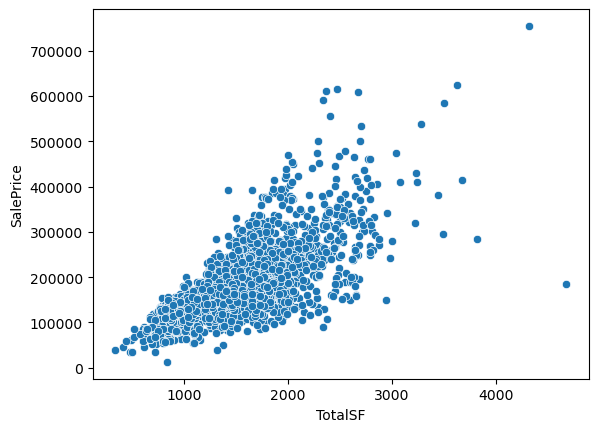

In [129]:
sns.scatterplot(x='TotalSF', y='SalePrice', data=sf_df);

This is heteroskedastic. Linear model will not capture relationship well.
Look more closely at each feature.

### Sale Price

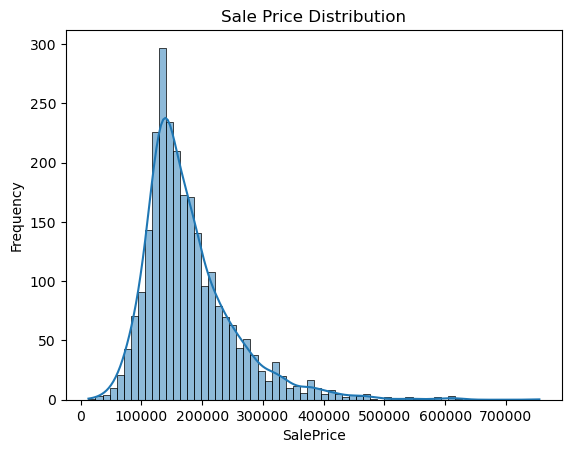

In [132]:
sns.histplot(sf_df['SalePrice'], kde=True)
plt.title('Sale Price Distribution')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show();

In [133]:
from scipy.stats import skew
skew(sf_df.SalePrice)

1.759777902149407

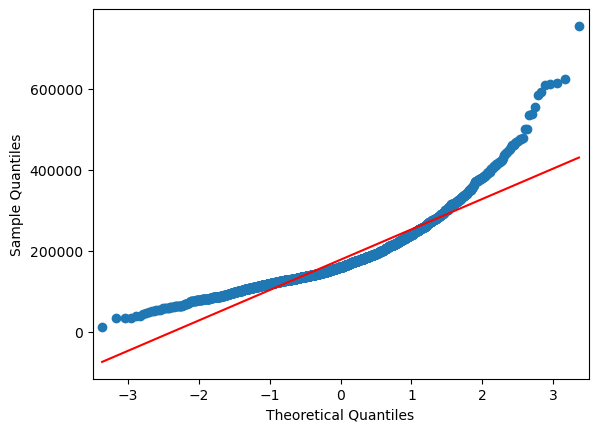

In [134]:
from statsmodels.graphics.gofplots import qqplot
qqplot(sf_df['SalePrice'], line = 's');

### Total Square Footage

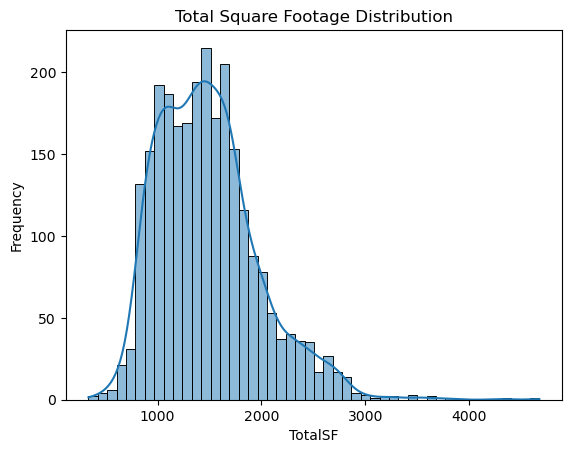

In [136]:
sns.histplot(sf_df['TotalSF'], kde=True)
plt.title('Total Square Footage Distribution')
plt.xlabel('TotalSF')
plt.ylabel('Frequency')
plt.show();

In [137]:
skew(sf_df.TotalSF)

0.9617262874132598

Is this appropriate for bimodal data? When is this not meaningful?
The retail homework (Retail Sale Modeling with Multiple Linear Regression) uses Salary, which is bimodal. The skew() value is 0.417, and is deemed not as severe as the target variable. 
How rough is this estimate and when (and what) other tools should be used? 

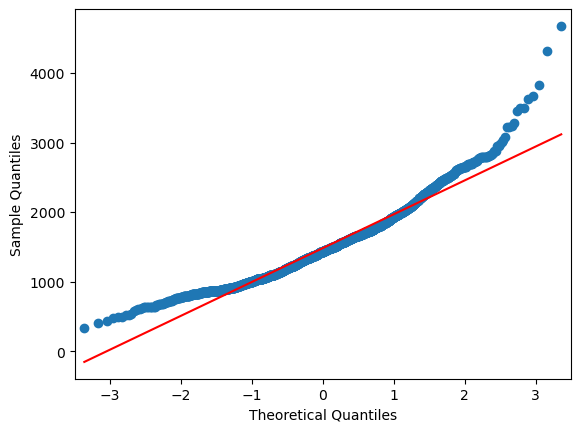

In [139]:
qqplot(sf_df['TotalSF'], line = 's');

How to understand the use of percentage ratios when transforming data...

The questions are:
- should I log transform the data, 
- which variables should I transform (linear-log, log-linear, or log-log transformation) 
- how to quantify this
- if i do transform the data, how do I interpret a model built on that transformed data

Because log transformed data preserves ratios and not differences within a feature, we look at their ratio and observe whether or not it changes linearly. If SalePrice increases proportionally with TotalSF, then the ratio should be roughly constant. If it varies, this suggests a nonlinear relationshiop that can be corrected with a log transformation. 

### Percentage ratio of SalePrice to TotalSF
Price / Square Foot

**Note:** cannot use price/sqft in model because it uses sale price --> data leakage! Use for EDA

In [142]:
sf_df.head(2) 

SalePrice  1stFlrSF  2ndFlrSF  TotalSF
0     126000       856         0      856
1     139500      1049         0     1049

In [143]:
sf_df['Price_per_SF'] = sf_df['SalePrice'] / sf_df['TotalSF']
sf_df.head()

SalePrice  1stFlrSF  2ndFlrSF  TotalSF  Price_per_SF
0     126000       856         0      856    147.196262
1     139500      1049         0     1049    132.983794
2     124900      1001         0     1001    124.775225
3     114000       717       322     1039    109.720885
4     227000       810       855     1665    136.336336

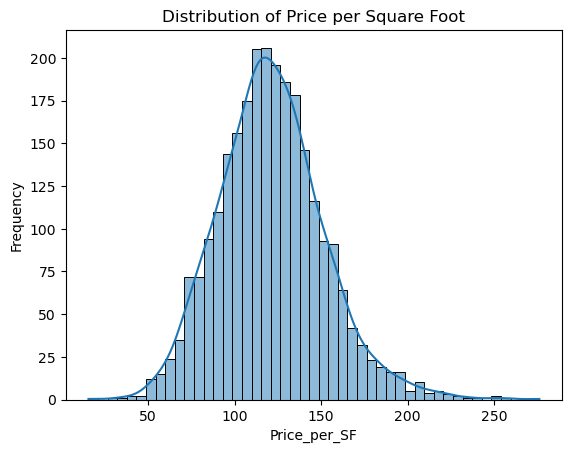

In [144]:
sns.histplot(sf_df['Price_per_SF'], kde=True)
plt.title('Distribution of Price per Square Foot')
plt.xlabel('Price_per_SF')
plt.ylabel('Frequency')
plt.show();

In [145]:
skew(sf_df.Price_per_SF)

0.45112712155714774

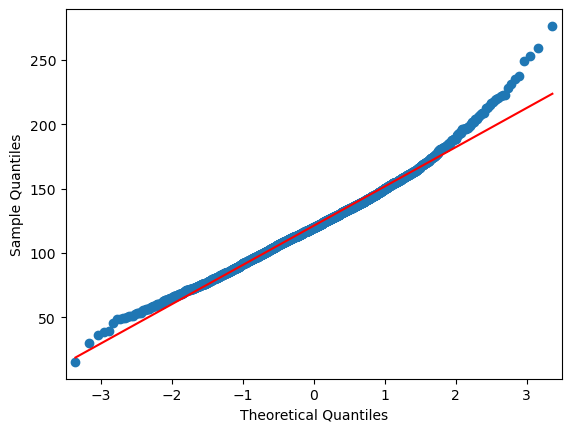

In [146]:
qqplot(sf_df['Price_per_SF'], line = 's');

Compare log transformations of SalePrice and TotalSF in order to see if transformed data could be used to build a linear regression model.

In [148]:
# Check for 0 values, for log calculations
sf_df[sf_df['TotalSF'] == 0]

Empty DataFrame
Columns: [SalePrice, 1stFlrSF, 2ndFlrSF, TotalSF, Price_per_SF]
Index: []

In [149]:
# Check for 0 values, for log calculations
sf_df[sf_df['SalePrice'] == 0]

Empty DataFrame
Columns: [SalePrice, 1stFlrSF, 2ndFlrSF, TotalSF, Price_per_SF]
Index: []

No risk of any log(0) values - no need to add small amount to columns

### Linear-log model

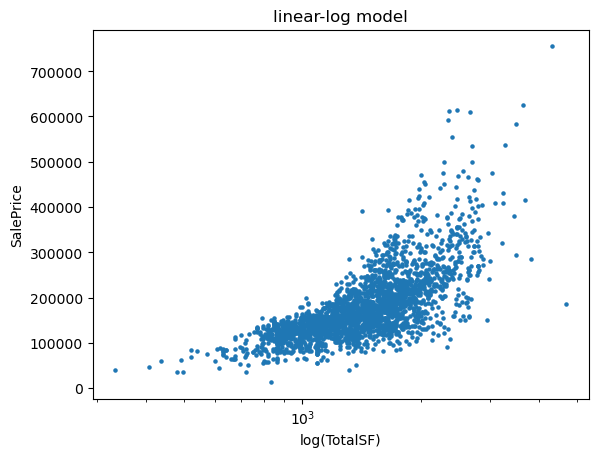

In [152]:
(sf_df[['SalePrice','TotalSF']]).plot(kind='scatter', x='TotalSF', \
                                           y='SalePrice', logx=True, logy=False, s=5)
plt.title('linear-log model')
plt.xlabel('log(TotalSF)')
plt.ylabel('SalePrice')
plt.show();

### Log-linear model

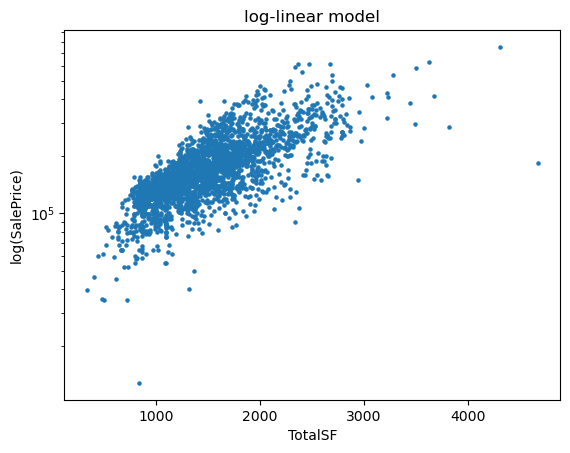

In [154]:
(sf_df[['SalePrice','TotalSF']]).plot(kind='scatter', x='TotalSF', \
                                           y='SalePrice', logx=False, logy=True, s=5)
plt.title('log-linear model')
plt.xlabel('TotalSF')
plt.ylabel('log(SalePrice)')
plt.show();

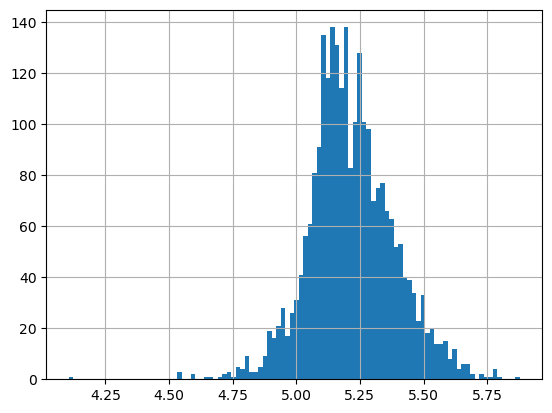

In [155]:
np.log10(sf_df.SalePrice).hist(bins=100);

In [156]:
skew(np.log10(sf_df.SalePrice))

0.041244968796023976

That looks great

### Log-log model

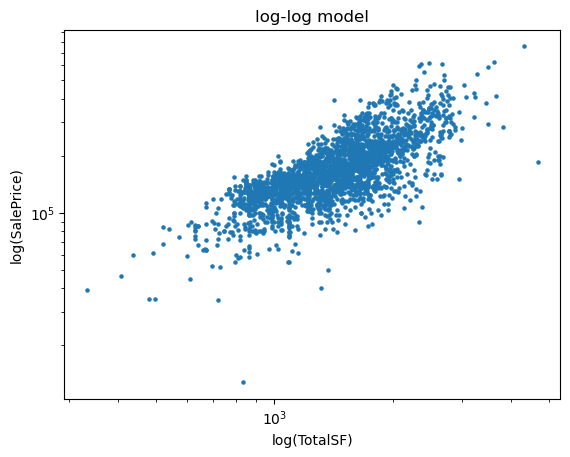

In [159]:
(sf_df[['SalePrice','TotalSF']]).plot(kind='scatter', x='TotalSF', \
                                           y='SalePrice', logx=True, logy=True, s=5)
plt.title('log-log model')
plt.xlabel('log(TotalSF)')
plt.ylabel('log(SalePrice)')
plt.show();

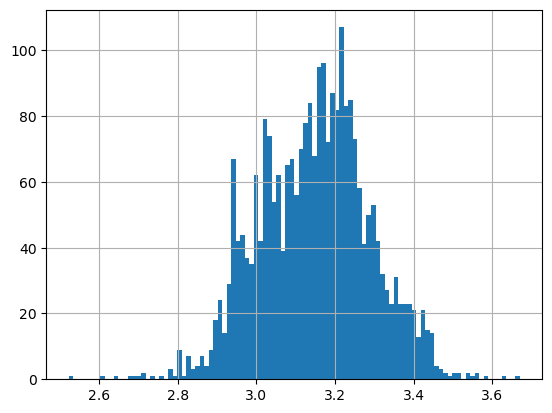

In [160]:
np.log10(sf_df.TotalSF).hist(bins=100);

In [161]:
skew(np.log10(sf_df.TotalSF))

-0.06976499439120813

This is also great.

Comparing log-log and log-linear models:

Which one is better? 
- log-log (transform both SalePrice and TotalSF)
- log-linear model (transform SalePrice only)

Both are normally distributed and comparable in skewness. 

TotalSF is a little less skewed.

Throw them both into a model and see? Is that best practice? 

In [164]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(sf_df[['TotalSF']], sf_df['SalePrice'])
print(f"Untransformed data regression score: {lm.score(sf_df[['TotalSF']], sf_df['SalePrice'])}")

Untransformed data regression score: 0.5265783693406463


In [165]:
lm.fit(sf_df[['TotalSF']], np.log10(sf_df['SalePrice']))
print(f"log-linear data regression score: {lm.score(sf_df[['TotalSF']], np.log10(sf_df['SalePrice']))}")

log-linear data regression score: 0.5242548310361531


In [166]:
lm.fit(np.log10(sf_df[['TotalSF']]), np.log10(sf_df['SalePrice']))
print(f"log-log data regression score: {lm.score(np.log10(sf_df[['TotalSF']]), np.log10(sf_df['SalePrice']))}")

log-log data regression score: 0.5477949931895834


Not much improvement, but log-log data improves the score by ~0.2.

Is it worth using log-log transformed data, with such a small improvement,
when the interpretation could be so difficult? 

Retail data had an improvement of ~0.6. 

The lecture suggested that, with the retail dataset, log 10 may not be the best base to use.

Question to pursue:
- What do log transformations in different bases look like?
- What does the data look like that would tell us this kind of transformation is worthwhile? 

Box-Cox transformation... when does the data suggest we use that? 

### Box-Cox transformation

Box-Cox function finds the best lambda that optimizes your data's distribution.

$$For λ ≠ 0: y(\lambda) = \frac{x^\lambda - 1}{\lambda}$$

$$For λ = 0: y(0) = \ln(x)$$

Where:
- x > 0 (original data must be positive)
- λ (lambda) is the transformation parameter
- y is the transformed data

When to use:
- When the goal is to maximize model performance.
- When interpretability is not critical (not as interpretable as log transformed data).
- When skewness > 1.0 (maybe when 0.5-1.0, but not < 0.5)

In [170]:
print(f'SalePrice skewness: {skew(sf_df.SalePrice)}')
print(f'TotalSF skewness: {skew(sf_df.TotalSF)}')

SalePrice skewness: 1.759777902149407
TotalSF skewness: 0.9617262874132598


In [171]:
from scipy import stats

In [172]:
sale_price_bc, sale_price_lambda = stats.boxcox(sf_df.SalePrice)

Lambda value used for Transformation: -0.02286261736032067


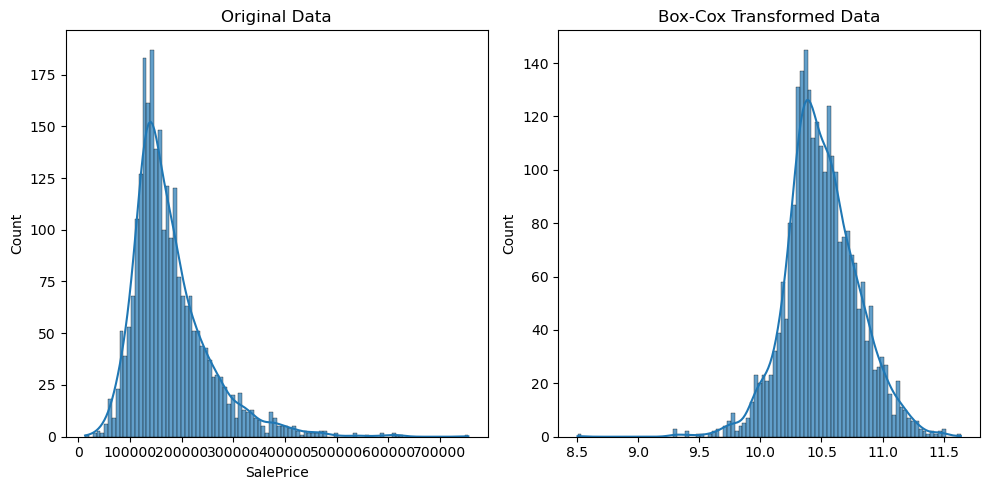

In [173]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(data=sf_df, x='SalePrice', kde=True, alpha=0.7, ax=ax[0], bins=100)
ax[0].set_title("Original Data")

# Right plot - Transformed data
sns.histplot(x=sale_price_bc, kde=True, alpha=0.7, ax=ax[1], bins=100)
ax[1].set_title("Box-Cox Transformed Data")

plt.tight_layout()
print(f"Lambda value used for Transformation: {sale_price_lambda}")
plt.show();

**Note:**
Lambda is close to zero, so the transformation is comparable to a log transformation.

In [175]:
total_sf_bc, total_sf_lambda = stats.boxcox(sf_df.TotalSF)

Lambda value used for Transformation: 0.07066450232207615


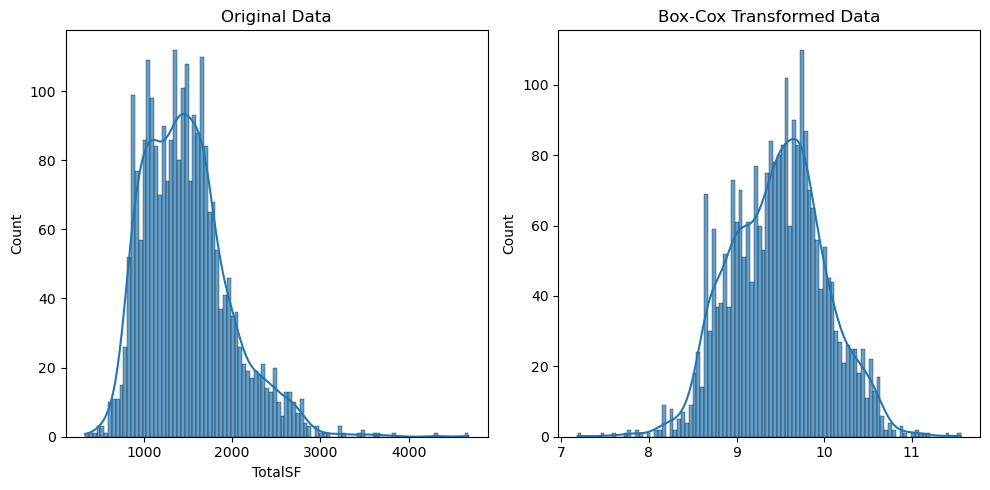

In [176]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(data=sf_df, x='TotalSF', kde=True, alpha=0.7, ax=ax[0], bins=100)
ax[0].set_title("Original Data")

# Right plot - Transformed data
sns.histplot(x=total_sf_bc, kde=True, alpha=0.7, ax=ax[1], bins=100)
ax[1].set_title("Box-Cox Transformed Data")

plt.tight_layout()
print(f"Lambda value used for Transformation: {total_sf_lambda}")
plt.show();

**Note:** This lambda is also close to zero, and comparable to a log transformation. 

Look at R2 scores just for fun.

In [178]:
lm = LinearRegression()
lm.fit(total_sf_bc.reshape(-1,1), sf_df['SalePrice'])
print(f"Box-Cox transformed regression score (TotalSF variable): {lm.score(total_sf_bc.reshape(-1,1), sf_df['SalePrice'])}")

Box-Cox transformed regression score (TotalSF variable): 0.49901052340963503


In [179]:
lm.fit(sf_df[['TotalSF']], sale_price_bc.reshape(-1,1))
print(f"Box-Cox transformed regression score (SalePrice variable): {lm.score(sf_df[['TotalSF']], sale_price_bc.reshape(-1,1))}")

Box-Cox transformed regression score (SalePrice variable): 0.5225871443434814


In [180]:
lm.fit(total_sf_bc.reshape(-1,1), sf_df['SalePrice'])
print(f"Box_cox data regression score (both variables): {lm.score(total_sf_bc.reshape(-1,1), sf_df['SalePrice'])}")

Box_cox data regression score (both variables): 0.49901052340963503


#### From above
Untransformed data regression score: 0.5265783693406463

linear-log data regression score: 0.4951183355276835 (log(TotalSF))

log-linear data regression score: 0.5242548310361531 (log(SalePrice))

log-log data regression score: 0.5477949931895834 (logs both variables)

Box-Cox transforming either TotalSF or SalePrice is not that different from transforming them logarthmically, as expected. Box-Cox transforming both variables in combination gives a much worse score than transforming both variables logarithmically. Why is that? ... 

BoxCox applies different scaling to each variable, which does not preserve the relationship between them in the lm model. Log Scaling applies the same, consistent scaling to both features.

### Visualization Aside:
creating marginal histograms.

In [183]:
sf_df.head(2)

SalePrice  1stFlrSF  2ndFlrSF  TotalSF  Price_per_SF
0     126000       856         0      856    147.196262
1     139500      1049         0     1049    132.983794

In [184]:
sf_df_vis = sf_df.copy()

In [185]:
sf_df_vis.head(2)

SalePrice  1stFlrSF  2ndFlrSF  TotalSF  Price_per_SF
0     126000       856         0      856    147.196262
1     139500      1049         0     1049    132.983794

In [186]:
col_zeros = []
for col in sf_df_vis.columns:
    if (sf_df_vis[col] == 0).any():
        col_zeros.append(col)

print("Columns with zero values:", col_zeros)

Columns with zero values: ['2ndFlrSF']


In [187]:
sf_df_vis['LogSalePrice'] = np.log(sf_df_vis['SalePrice'])
sf_df_vis['Log1stFlrSF'] = np.log(sf_df_vis['1stFlrSF'])
sf_df_vis['Log2ndFlrSF'] = np.log(sf_df_vis['2ndFlrSF']+1e-3)
sf_df_vis['LogTotalSF'] = np.log(sf_df_vis['TotalSF'])

### Side by side plots

In [189]:
sf_df_vis.head(2)

SalePrice  1stFlrSF  2ndFlrSF  TotalSF  Price_per_SF  LogSalePrice  \
0     126000       856         0      856    147.196262     11.744037   
1     139500      1049         0     1049    132.983794     11.845820   

   Log1stFlrSF  Log2ndFlrSF  LogTotalSF  
0     6.752270    -6.907755    6.752270  
1     6.955593    -6.907755    6.955593

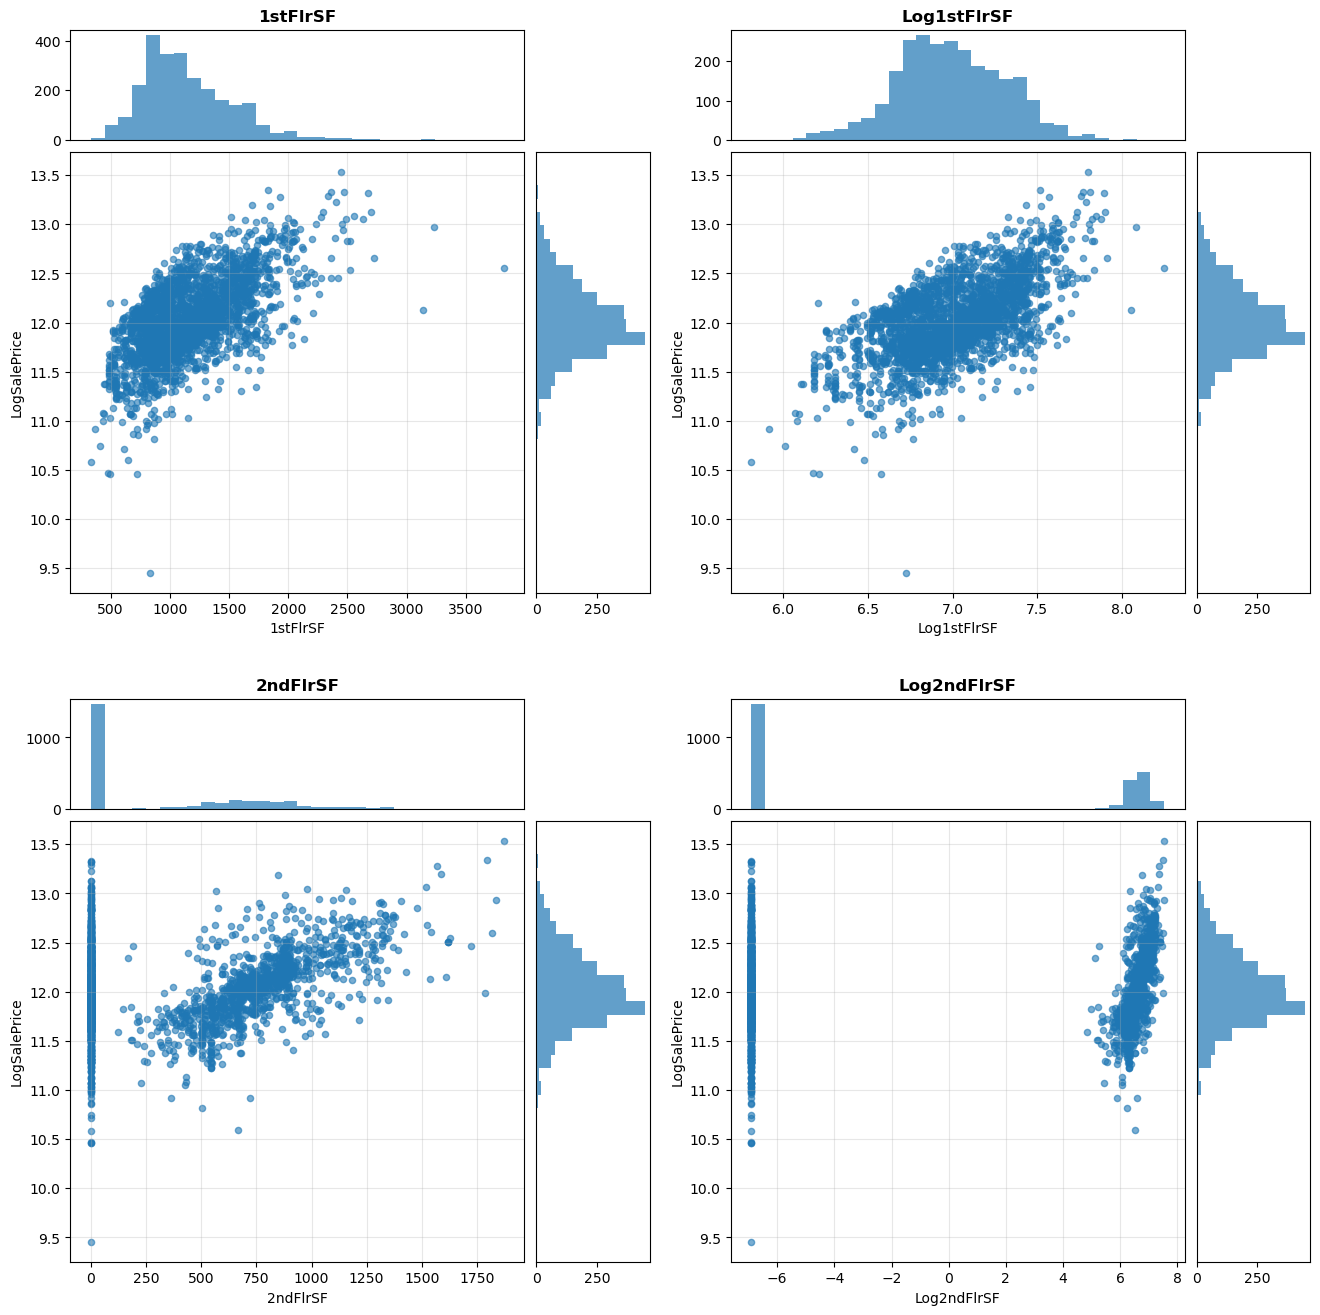

In [190]:
# Alternative simpler version using subplots
fig, axes = plt.subplots(5, 5, figsize=(16, 16), 
                        gridspec_kw={'height_ratios': [1, 4, 0.75, 1, 4], 'width_ratios': [4, 1, 0.5, 4, 1],
                                    'hspace': 0.05, 'wspace': 0.05})

# 1stFlrSF comparison
# First plot set (columns 0, 1)
axes[0, 0].hist(sf_df_vis['1stFlrSF'], bins=30, alpha=0.7)
axes[0, 0].set_title('1stFlrSF', fontweight='bold')
axes[0, 0].set_xticks([])

axes[1, 0].scatter(sf_df_vis['1stFlrSF'], sf_df_vis['LogSalePrice'], alpha=0.6, s=20)
axes[1, 0].set_xlabel('1stFlrSF')
axes[1, 0].set_ylabel('LogSalePrice')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(sf_df_vis['LogSalePrice'], bins=30, orientation='horizontal', 
                alpha=0.7)
axes[1, 1].set_yticks([])

# Second plot set (columns 3, 4)
axes[0, 3].hist(sf_df_vis['Log1stFlrSF'], bins=30, alpha=0.7)
axes[0, 3].set_title('Log1stFlrSF', fontweight='bold')
axes[0, 3].set_xticks([])

axes[1, 3].scatter(sf_df_vis['Log1stFlrSF'], sf_df_vis['LogSalePrice'], alpha=0.6, s=20)
axes[1, 3].set_xlabel('Log1stFlrSF')
axes[1, 3].set_ylabel('LogSalePrice')
axes[1, 3].grid(True, alpha=0.3)

axes[1, 4].hist(sf_df_vis['LogSalePrice'], bins=30, orientation='horizontal', 
                alpha=0.7)
axes[1, 4].set_yticks([])

# Hide the unused top-right subplots
axes[0, 1].axis('off')
axes[0, 4].axis('off')
# for spacing
axes[0, 2].axis('off')
axes[1, 2].axis('off')

# 2ndFlrSF comparison 
# First plot set
axes[3, 0].hist(sf_df_vis['2ndFlrSF'], bins=30, alpha=0.7)
axes[3, 0].set_title('2ndFlrSF', fontweight='bold')
axes[3, 0].set_xticks([])

axes[4, 0].scatter(sf_df_vis['2ndFlrSF'], sf_df_vis['LogSalePrice'], alpha=0.6, s=20)
axes[4, 0].set_xlabel('2ndFlrSF')
axes[4, 0].set_ylabel('LogSalePrice')
axes[4, 0].grid(True, alpha=0.3)

axes[4, 1].hist(sf_df_vis['LogSalePrice'], bins=30, orientation='horizontal', 
                alpha=0.7)
axes[4, 1].set_yticks([])

# Second plot set
axes[3, 3].hist(sf_df_vis['Log2ndFlrSF'], bins=30, alpha=0.7)
axes[3, 3].set_title('Log2ndFlrSF', fontweight='bold')
axes[3, 3].set_xticks([])

axes[4, 3].scatter(sf_df_vis['Log2ndFlrSF'], sf_df_vis['LogSalePrice'], alpha=0.6, s=20)
axes[4, 3].set_xlabel('Log2ndFlrSF')
axes[4, 3].set_ylabel('LogSalePrice')
axes[4, 3].grid(True, alpha=0.3)

axes[4, 4].hist(sf_df_vis['LogSalePrice'], bins=30, orientation='horizontal', 
                alpha=0.7)
axes[4, 4].set_yticks([])

# Hide the unused top-right subplots
axes[3, 1].axis('off')
axes[3, 4].axis('off')
# for spacing
axes[3, 2].axis('off')
axes[4, 2].axis('off')

axes[2, 0].axis('off')
axes[2, 1].axis('off')
axes[2, 2].axis('off')
axes[2, 3].axis('off')
axes[2, 4].axis('off')

plt.show()

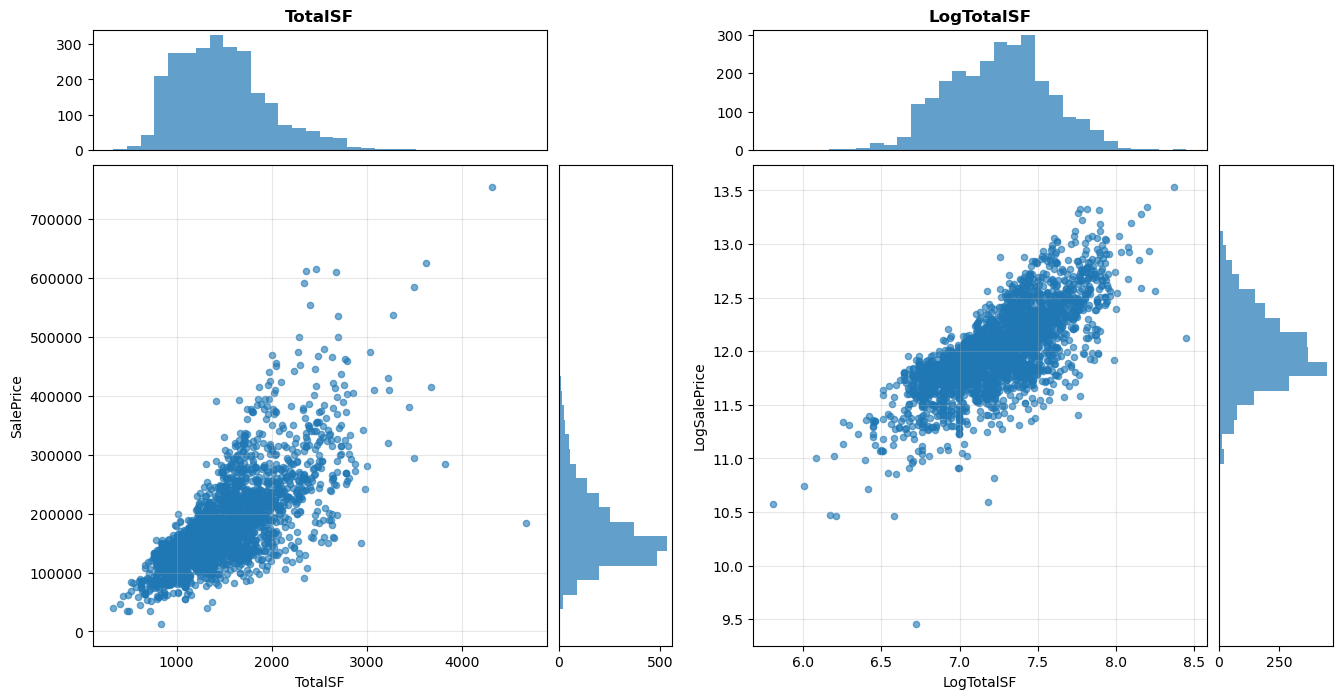

In [191]:
fig, axes = plt.subplots(2, 5, figsize=(16, 8), 
                        gridspec_kw={'height_ratios': [1, 4], 'width_ratios': [4, 1, 0.5, 4, 1],
                                    'hspace': 0.05, 'wspace': 0.05})

# SalePrice and TotalSF
axes[0, 0].hist(sf_df_vis['TotalSF'], bins=30, alpha=0.7)
axes[0, 0].set_title('TotalSF', fontweight='bold')
axes[0, 0].set_xticks([])

axes[1, 0].scatter(sf_df_vis['TotalSF'], sf_df_vis['SalePrice'], alpha=0.6, s=20)
axes[1, 0].set_xlabel('TotalSF')
axes[1, 0].set_ylabel('SalePrice')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(sf_df_vis['SalePrice'], bins=30, orientation='horizontal', 
                alpha=0.7)
axes[1, 1].set_yticks([])

# LogSalePrice and LogTotalSF
axes[0, 3].hist(sf_df_vis['LogTotalSF'], bins=30, alpha=0.7)
axes[0, 3].set_title('LogTotalSF', fontweight='bold')
axes[0, 3].set_xticks([])

axes[1, 3].scatter(sf_df_vis['LogTotalSF'], sf_df_vis['LogSalePrice'], alpha=0.6, s=20)
axes[1, 3].set_xlabel('LogTotalSF')
axes[1, 3].set_ylabel('LogSalePrice')
axes[1, 3].grid(True, alpha=0.3)

axes[1, 4].hist(sf_df_vis['LogSalePrice'], bins=30, orientation='horizontal', 
                alpha=0.7)
axes[1, 4].set_yticks([])

# Hide the unused subplots
axes[0, 1].axis('off')
axes[0, 2].axis('off')
axes[0, 4].axis('off')
axes[1, 2].axis('off')

plt.show()

# Categorical feature analysis
[Contents](#Contents)

ANOVA tests for categorical features with more than 2 subcategories

Why do we do this? 
- to see what features have subcategories worth exploring by looking at distributions of subcategories and deprioritizing features with a lot of uniformity throughout the dataset.
    - if a feature (like Neighborhood) has a range of sale prices associated with different neighborhoods, certain subcategories may be worth exploring.
    - if few houses have pools, or every house is on a paved street, then this is not very interesting and these features may not be worth keeping

In [194]:
# make sure we are working with imputed data
ames.isnull().sum().sum()

0

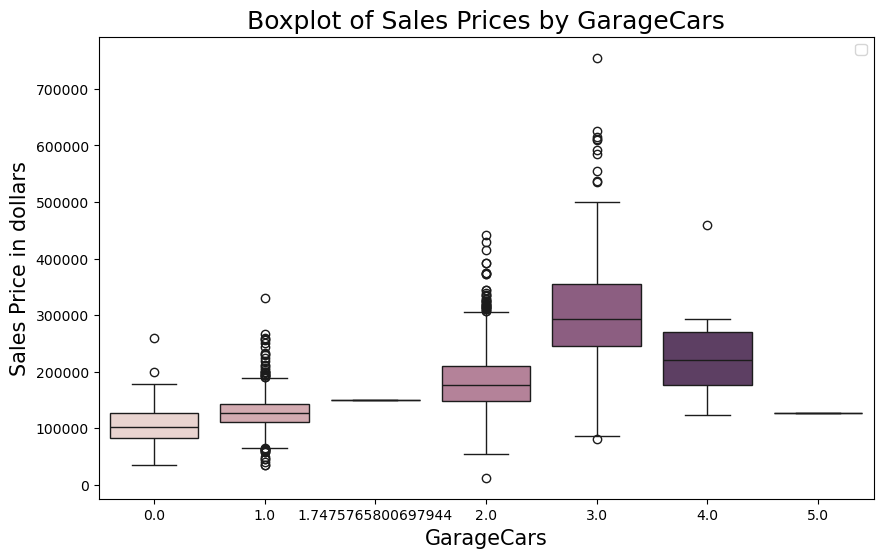

In [195]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=ames['GarageCars'], y=ames['SalePrice'], hue=ames['GarageCars'])
plt.title('Boxplot of Sales Prices by GarageCars', fontsize=18)
plt.xlabel('GarageCars', fontsize=15)
plt.ylabel('Sales Price in dollars', fontsize=15)
plt.legend('')
plt.show()

In [196]:
# Get mean data
garage_cars_data = ames.groupby('GarageCars')['SalePrice'].agg(['mean', 'median']).round(2)
garage_cars_data['diff'] = garage_cars_data['mean'] - garage_cars_data['median']
print(garage_cars_data)

                 mean    median      diff
GarageCars                               
0.000000    106048.62  102000.0   4048.62
1.000000    128544.38  128000.0    544.38
1.747577    150909.00  150909.0      0.00
2.000000    183228.87  176500.0   6728.87
3.000000    305562.36  293200.0  12362.36
4.000000    231748.50  221250.0  10498.50
5.000000    126500.00  126500.0      0.00


In [197]:
ames['GarageCars'].value_counts()

GarageCars
2.000000    1439
1.000000     713
3.000000     285
0.000000     127
4.000000      14
1.747577       1
5.000000       1
Name: count, dtype: int64

In [198]:
garage_categories = sorted(ames['GarageCars'].unique())
garage_categories

[0.0, 1.0, 1.7475765800697944, 2.0, 3.0, 4.0, 5.0]

/var/folders/tn/yy89yz_94q5b571nxcz7c_2m0000gn/T/ipykernel_72573/4028372565.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=category_data,
/var/folders/tn/yy89yz_94q5b571nxcz7c_2m0000gn/T/ipykernel_72573/4028372565.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=category_data,


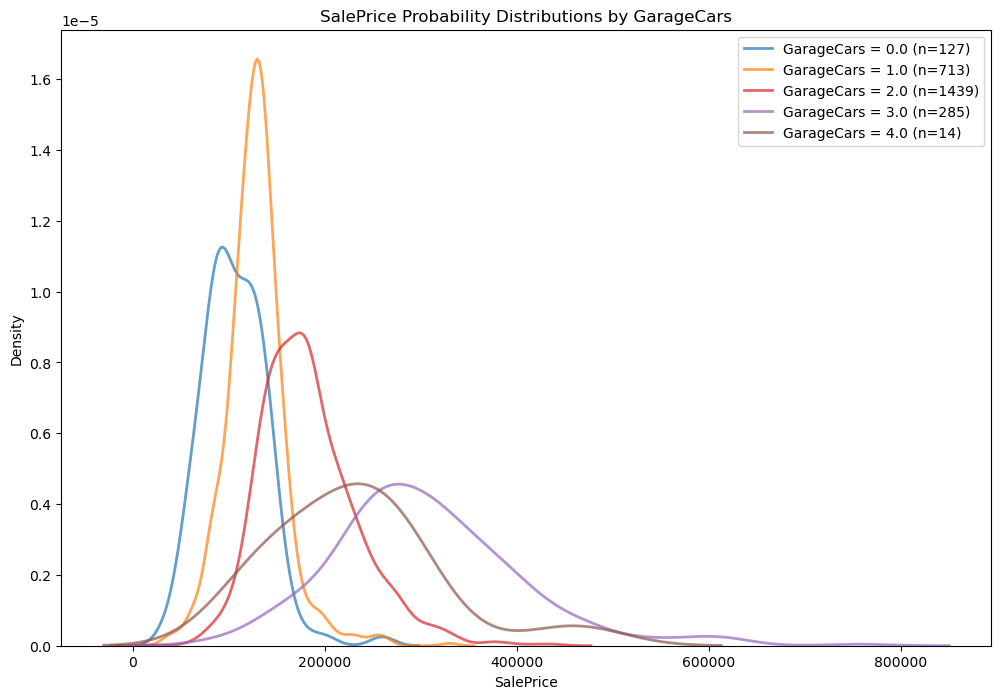

In [199]:
plt.figure(figsize=(12, 8))

for garage_cars in garage_categories:
    category_data = ames[ames['GarageCars'] == garage_cars]['SalePrice']
    sns.kdeplot(data=category_data, 
               label=f'GarageCars = {garage_cars} (n={len(category_data)})', 
               alpha=0.7, linewidth=2)

plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.title('SalePrice Probability Distributions by GarageCars')
plt.legend()
plt.show()

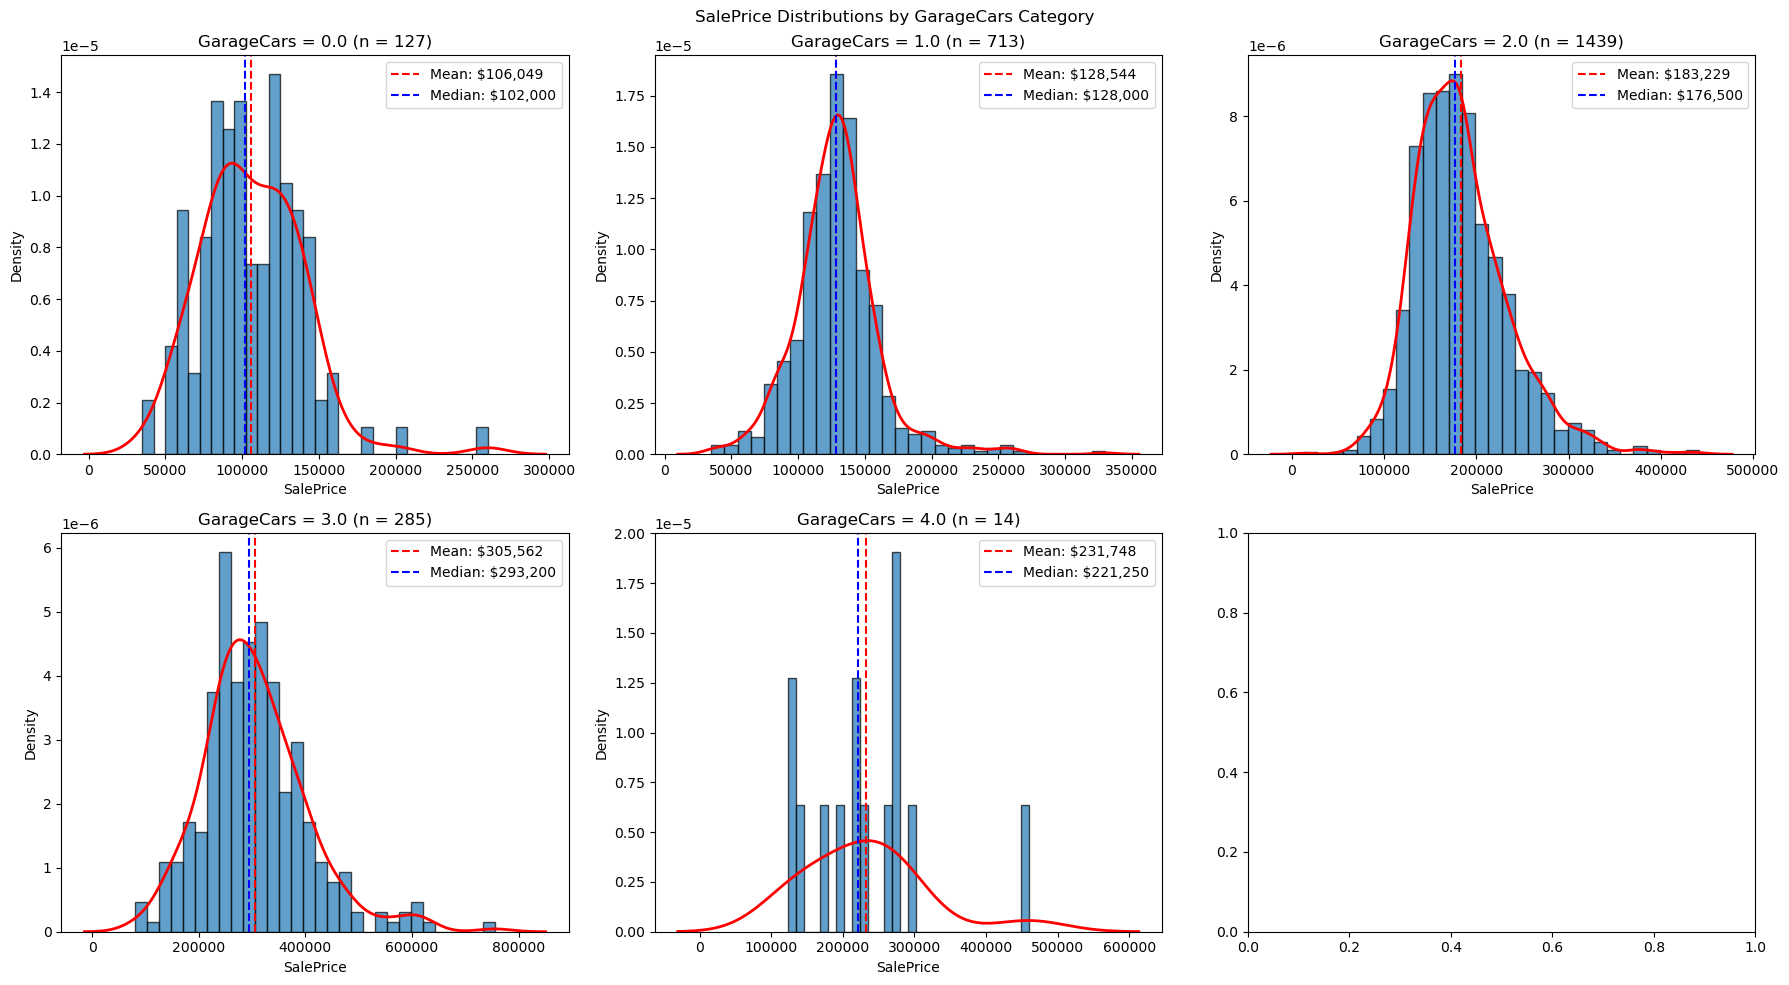

In [200]:
# Individual histograms with KDE curves (excluding houses with 1.75 and 5 car garages)
garage_categories = [0.0, 1.0, 2.0, 3.0, 4.0]
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, garage_cars in enumerate(garage_categories):
    category_data = ames[ames['GarageCars'] == garage_cars]['SalePrice']
    
    # Histogram + KDE
    axes[i].hist(category_data, bins=30, alpha=0.7, density=True, edgecolor='black')
    sns.kdeplot(category_data, ax=axes[i], color='red', linewidth=2)
    
    # Add mean and median lines
    axes[i].axvline(category_data.mean(), color='red', linestyle='--', 
                   label=f'Mean: ${category_data.mean():,.0f}')
    axes[i].axvline(category_data.median(), color='blue', linestyle='--', 
                   label=f'Median: ${category_data.median():,.0f}')
    
    axes[i].set_title(f'GarageCars = {garage_cars} (n = {len(category_data)})')
    axes[i].legend()

plt.suptitle('SalePrice Distributions by GarageCars Category')
plt.tight_layout()
plt.show()

In [201]:
ames['GarageCars']

0       2.0
1       1.0
2       1.0
3       1.0
4       2.0
       ... 
2575    1.0
2576    2.0
2577    3.0
2578    2.0
2579    2.0
Name: GarageCars, Length: 2580, dtype: float64

In [202]:
import scipy.stats as stats
 
# Perform the ANOVA
f_value, p_value = stats.f_oneway(*[ames['SalePrice'][ames['GarageCars'] == num]
                                    for num in ames['GarageCars'].unique()
                                   if num in [1.0, 2.0, 3.0, 4.0]])
 
print(f_value, p_value)

722.0397095202044 0.0


# Multicollinearity

see *Ames_Linear_Modeling3.ipynb*, feature engineering (Area and SF features...)

[Return To Top](#Contents)

In [204]:
# Necessary libraries: 

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [205]:
ames.columns

Index(['GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning', 'LotFrontage',
       'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'Pav

In [206]:
numeric_features.columns

Index(['GrLivArea', 'SalePrice', 'MSSubClass', 'LotFrontage', 'LotArea',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

In [207]:
correl_data_with_target = ames[['SalePrice', 'GrLivArea', 'MSSubClass', 'LotFrontage', 'LotArea',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold']]

In [208]:
# look at correlation values for numeric features, without SalePrice (target) and PID
correl_data = ames[['GrLivArea', 'MSSubClass', 'LotFrontage', 'LotArea',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold']]
correl_data

GrLivArea MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  \
0           856         30    68.516053     7890            6            6   
1          1049        120    42.000000     4235            5            5   
2          1001         30    60.000000     6060            5            9   
3          1039         70    80.000000     8146            4            8   
4          1665         60    70.000000     8400            8            6   
...         ...        ...          ...      ...          ...          ...   
2575        952         30    68.516053     8854            6            6   
2576       1733         20    68.516053    13680            3            5   
2577       2002         90    82.000000     6270            5            6   
2578       1842         60    68.516053     8826            7            5   
2579       1911         60    80.000000     9554            8            5   

      YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  GarageArea  \
0          1939          1950         0.0       238.0  ...       399.0   
1          1984          1984       149.0       552.0  ...       266.0   
2          1930          2007         0.0       737.0  ...       216.0   
3          1900          2003         0.0         0.0  ...       281.0   
4          2001          2001         0.0       643.0  ...       528.0   
...         ...           ...         ...         ...  ...         ...   
2575       1916          1950         0.0         0.0  ...       192.0   
2576       1955          1955         0.0         0.0  ...       452.0   
2577       1949          1950         0.0       284.0  ...       871.0   
2578       2000          2000       144.0       841.0  ...       486.0   
2579       1993          1994       125.0       380.0  ...       471.0   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
0              0            0              0          0          166   
1              0          105              0          0            0   
2            154            0             42         86            0   
3              0            0            168          0          111   
4              0           45              0          0            0   
...          ...          ...            ...        ...          ...   
2575           0           98              0          0           40   
2576           0            0              0          0            0   
2577           0            0              0          0            0   
2578         193           96              0          0            0   
2579         182           81              0          0            0   

      PoolArea  MiscVal  MoSold  YrSold  
0            0        0       3    2010  
1            0        0       2    2009  
2            0        0      11    2007  
3            0        0       5    2009  
4            0        0      11    2009  
...        ...      ...     ...     ...  
2575         0        0       5    2009  
2576         0        0       6    2009  
2577         0        0       8    2007  
2578         0        0       7    2007  
2579         0        0       9    2006  

[2580 rows x 36 columns]

In [209]:
corr_matrix = correl_data.corr()
corr_matrix

GrLivArea  MSSubClass  LotFrontage   LotArea  OverallQual  \
GrLivArea       1.000000    0.070785     0.311469  0.260322     0.559897   
MSSubClass      0.070785    1.000000    -0.407005 -0.198040     0.056468   
LotFrontage     0.311469   -0.407005     1.000000  0.341602     0.166868   
LotArea         0.260322   -0.198040     0.341602  1.000000     0.080607   
OverallQual     0.559897    0.056468     0.166868  0.080607     1.000000   
OverallCond    -0.105670   -0.075542    -0.048723 -0.032693    -0.095927   
YearBuilt       0.228400    0.053852     0.094070  0.012397     0.574400   
YearRemodAdd    0.306035    0.056756     0.059027  0.010293     0.546297   
MasVnrArea      0.386732    0.017809     0.183859  0.103385     0.404809   
BsmtFinSF1      0.164852   -0.074081     0.161860  0.163460     0.273800   
BsmtFinSF2     -0.021051   -0.074080     0.048251  0.082335    -0.030370   
BsmtUnfSF       0.245476   -0.113240     0.094847  0.019737     0.255587   
TotalBsmtSF     0.409698   -0.221898     0.282488  0.222031     0.527840   
1stFlrSF        0.539135   -0.255798     0.400367  0.313086     0.454481   
2ndFlrSF        0.665001    0.306929     0.005005  0.022434     0.246885   
LowQualFinSF    0.088931    0.013473    -0.010019 -0.000334    -0.044359   
BsmtFullBath    0.044538   -0.002150     0.095857  0.118307     0.173247   
BsmtHalfBath   -0.053149   -0.010577    -0.025551  0.027474    -0.050543   
FullBath        0.643937    0.144475     0.151993  0.124352     0.508255   
HalfBath        0.445513    0.181780     0.024053  0.026727     0.271455   
BedroomAbvGr    0.538022   -0.023680     0.222554  0.140430     0.067466   
KitchenAbvGr    0.129797    0.251357     0.017124 -0.014575    -0.153691   
TotRmsAbvGrd    0.807445    0.032047     0.311132  0.204545     0.360675   
Fireplaces      0.457926   -0.047790     0.220864  0.245148     0.387777   
GarageYrBlt     0.258450    0.105169     0.046649 -0.016421     0.533055   
GarageCars      0.494964   -0.031962     0.281818  0.175733     0.580957   
GarageArea      0.477107   -0.091176     0.314406  0.199241     0.538121   
WoodDeckSF      0.247716   -0.017656     0.107287  0.155687     0.250181   
OpenPorchSF     0.321777   -0.007649     0.130789  0.084963     0.286861   
EnclosedPorch   0.000196   -0.028535     0.003170  0.017694    -0.134291   
3SsnPorch       0.008714   -0.041798     0.030235  0.017721     0.014226   
ScreenPorch     0.097835   -0.055099     0.076502  0.053820     0.049277   
PoolArea        0.057935   -0.013431     0.086013  0.052636    -0.002484   
MiscVal        -0.003940   -0.027226     0.012514  0.040220    -0.025825   
MoSold          0.038389    0.007252     0.001972  0.010203     0.016780   
YrSold         -0.008260   -0.025351    -0.002329 -0.017319     0.005668   

               OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
GrLivArea        -0.105670   0.228400      0.306035    0.386732    0.164852   
MSSubClass       -0.075542   0.053852      0.056756    0.017809   -0.074081   
LotFrontage      -0.048723   0.094070      0.059027    0.183859    0.161860   
LotArea          -0.032693   0.012397      0.010293    0.103385    0.163460   
OverallQual      -0.095927   0.574400      0.546297    0.404809    0.273800   
OverallCond       1.000000  -0.397274      0.065100   -0.143872   -0.064328   
YearBuilt        -0.397274   1.000000      0.572276    0.306163    0.303577   
YearRemodAdd      0.065100   0.572276      1.000000    0.174900    0.156444   
MasVnrArea       -0.143872   0.306163      0.174900    1.000000    0.276361   
BsmtFinSF1       -0.064328   0.303577      0.156444    0.276361    1.000000   
BsmtFinSF2        0.029981  -0.009806     -0.051175   -0.009512   -0.058911   
BsmtUnfSF        -0.123962   0.092159      0.130580    0.080103   -0.480927   
TotalBsmtSF      -0.179420   0.400931      0.271800    0.360888    0.512642   
1stFlrSF         -0.156592   0.294691      0.217709    0.361545    0.426727   
2ndFlrSF         

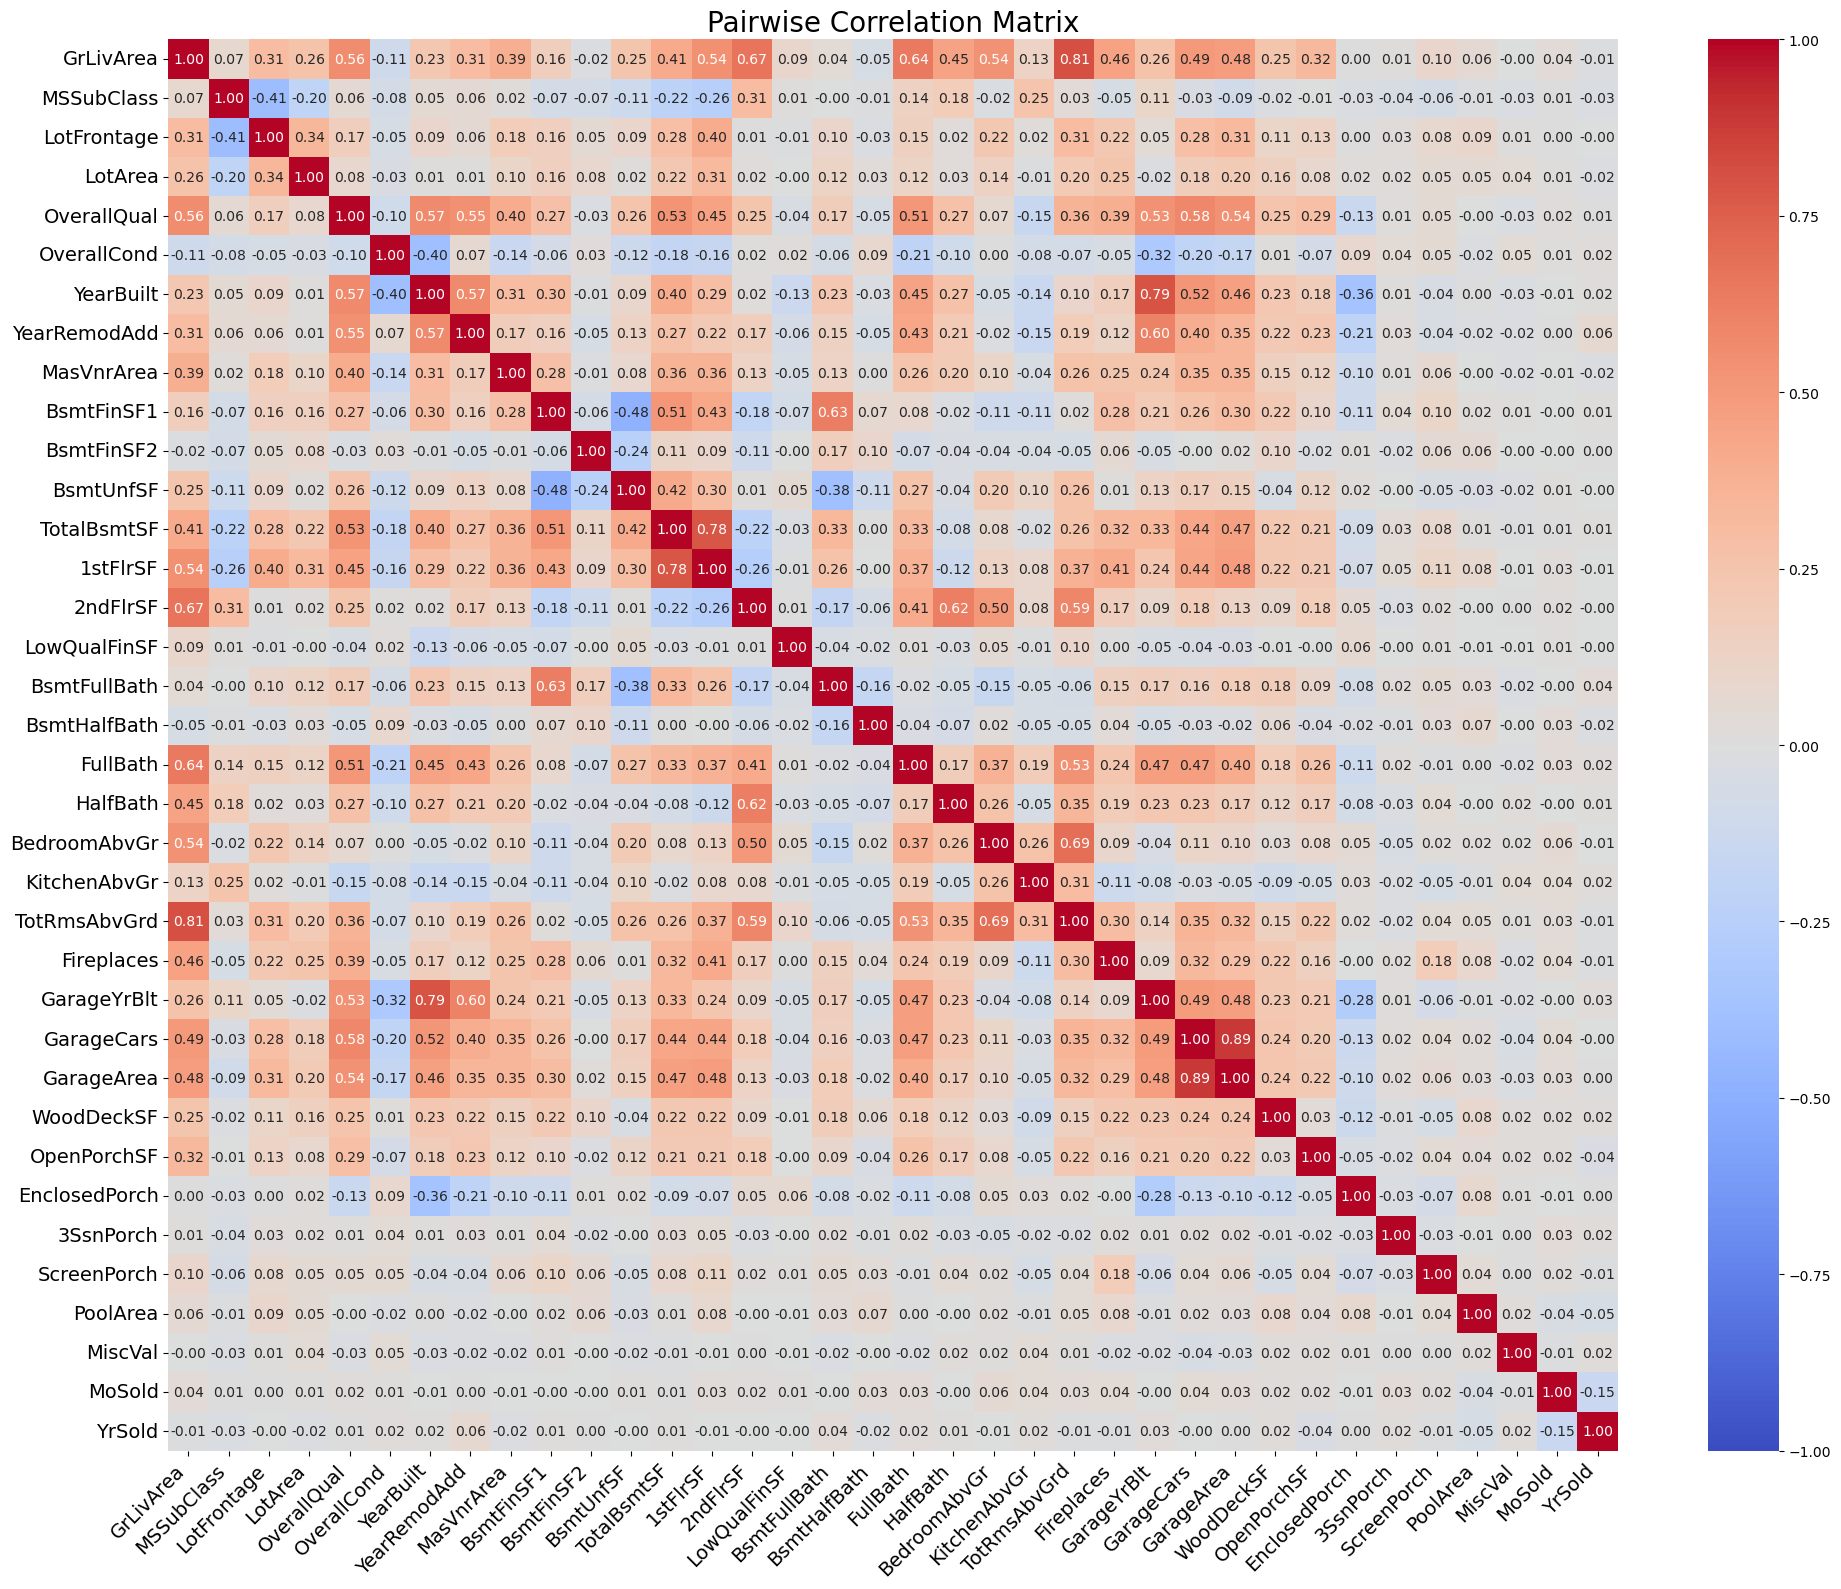

In [210]:
# visualize the correlations

plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
            annot_kws={'size': 10}, 
            fmt='.2f',  # Show only 2 decimal places
            xticklabels=True, yticklabels=True)
plt.xticks(fontsize=14, rotation=45, ha='right')
plt.yticks(fontsize=14)
plt.title('Pairwise Correlation Matrix', fontsize=20)
plt.tight_layout()
plt.show()

# OverallQual and OverallCond

[Return To Top](#Contents)

In [221]:
ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   GrLivArea      2580 non-null   int64  
 1   SalePrice      2580 non-null   int64  
 2   MSSubClass     2580 non-null   object 
 3   MSZoning       2580 non-null   object 
 4   LotFrontage    2580 non-null   float64
 5   LotArea        2580 non-null   int64  
 6   Street         2580 non-null   object 
 7   Alley          2580 non-null   object 
 8   LotShape       2580 non-null   object 
 9   LandContour    2580 non-null   object 
 10  Utilities      2580 non-null   object 
 11  LotConfig      2580 non-null   object 
 12  LandSlope      2580 non-null   object 
 13  Neighborhood   2580 non-null   object 
 14  Condition1     2580 non-null   object 
 15  Condition2     2580 non-null   object 
 16  BldgType       2580 non-null   object 
 17  HouseStyle     2580 non-null   object 
 18  OverallQ

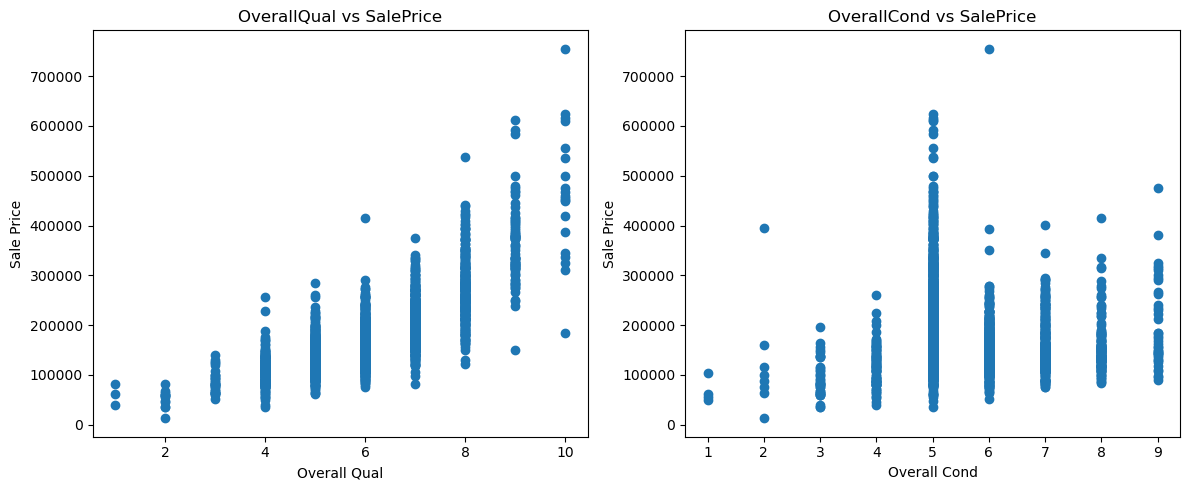

In [223]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(ames['OverallQual'], ames['SalePrice'])
ax1.set_xlabel('Overall Qual')
ax1.set_ylabel('Sale Price')
ax1.set_title('OverallQual vs SalePrice')

ax2.scatter(ames['OverallCond'], ames['SalePrice'])
ax2.set_xlabel('Overall Cond')
ax2.set_ylabel('Sale Price')
ax2.set_title('OverallCond vs SalePrice') 

plt.tight_layout()
plt.show()

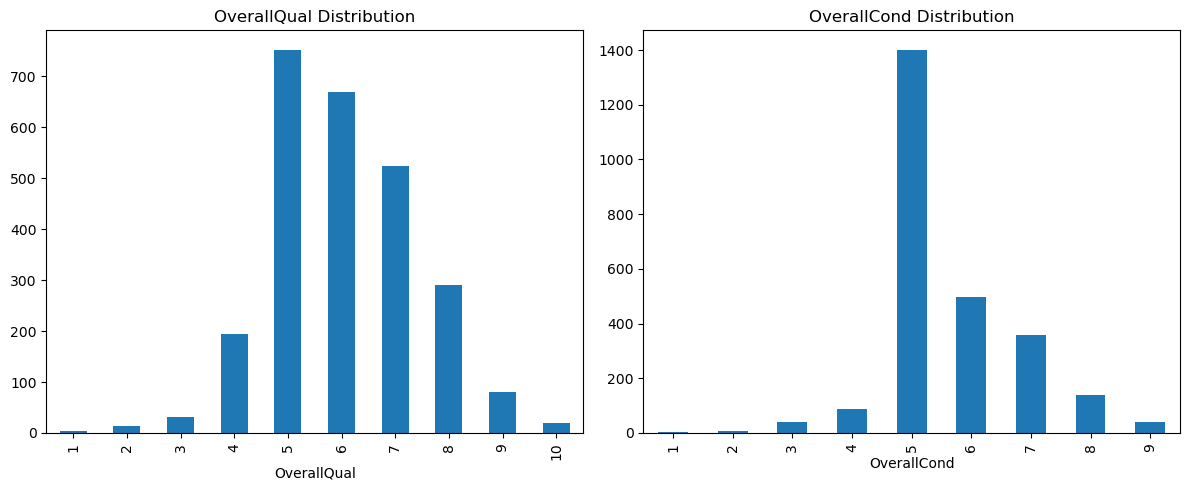

In [225]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ames['OverallQual'].value_counts().sort_index().plot(kind='bar', ax=ax1)
ames['OverallCond'].value_counts().sort_index().plot(kind='bar', ax=ax2)

ax1.set_title('OverallQual Distribution')
ax2.set_title('OverallCond Distribution')
plt.tight_layout()
plt.show()

# Resources
[Return To Top](#Contents)

**Dean De Cock paper and original data:**

https://jse.amstat.org/v19n3/decock.pdf

https://jse.amstat.org/v19n3/decock/DataDocumentation.txt

[Ames Data Dictionary](https://github.com/Padre-Media/dataset/blob/main/Ames%20Data%20Dictionary.txt)

[Exploring Dictionaries, Classifying Variables, and Imputing Data in the Ames Dataset](https://machinelearningmastery.com/classifying_variables/)

[Revealing the Invisible: Visualizing Missing Values in Ames Housing](https://machinelearningmastery.com/revealing_the_invisible/)

[Log Models, Ken Benoit](https://kenbenoit.net/assets/courses/me104/logmodels2.pdf)

Multicollinearity and VIF
- https://www.datacamp.com/tutorial/multicollinearity

# Extra

Text(0.5, 1.02, '1stFlrSF')

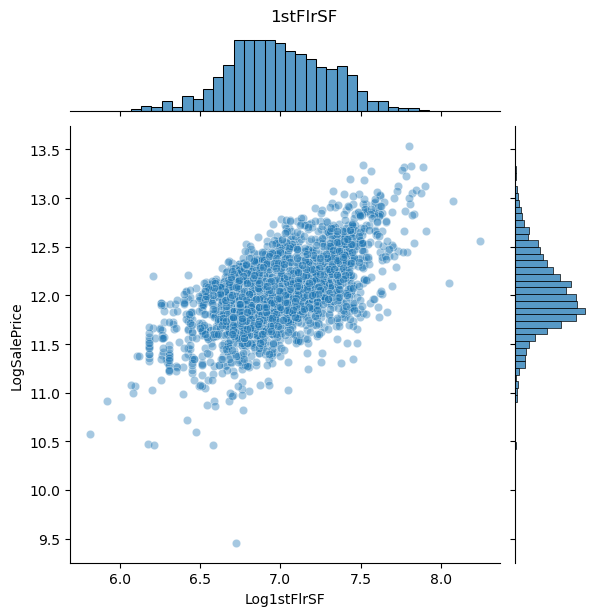

In [234]:
g1 = sns.jointplot(
    data=sf_df_vis,
    x="Log1stFlrSF",
    y="LogSalePrice",
    kind="scatter",
    alpha=0.4
)
g1.fig.suptitle("1stFlrSF", y=1.02)

Text(0.5, 1.02, '2ndFlrSF')

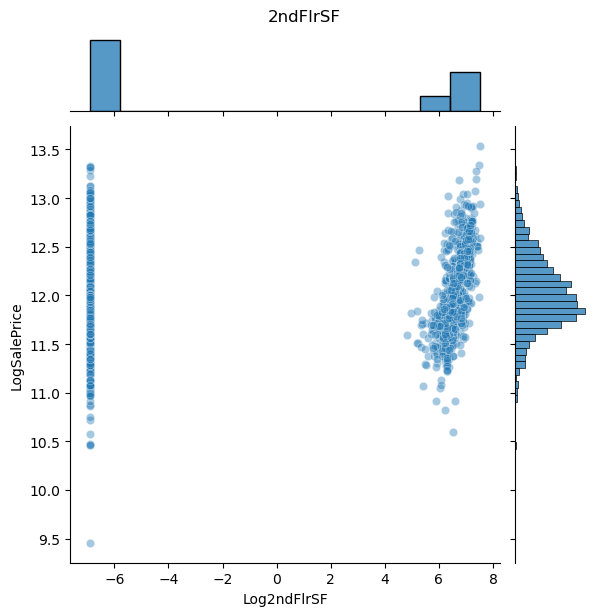

In [236]:
g2 = sns.jointplot(
    data=sf_df_vis,
    x="Log2ndFlrSF",
    y="LogSalePrice",
    kind="scatter",
    alpha=0.4
)
g2.fig.suptitle("2ndFlrSF", y=1.02)

Text(0.5, 1.02, 'TotalSF')

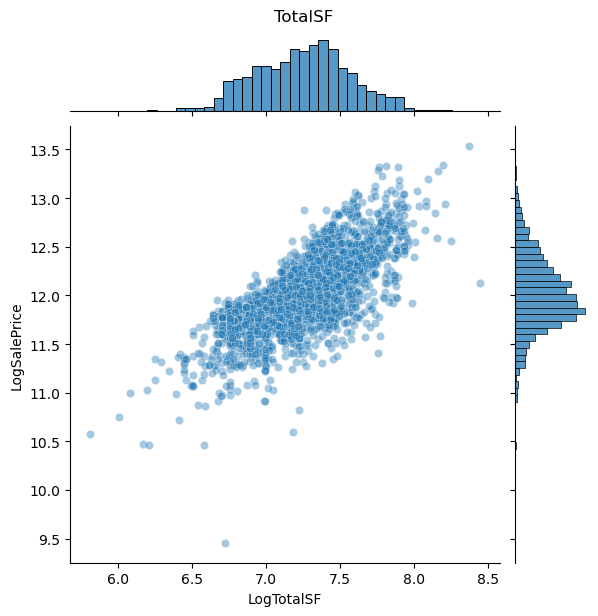

In [238]:
g3 = sns.jointplot(
    data=sf_df_vis,
    x="LogTotalSF",
    y="LogSalePrice",
    kind="scatter",
    alpha=0.4
)
g3.fig.suptitle("TotalSF", y=1.02)

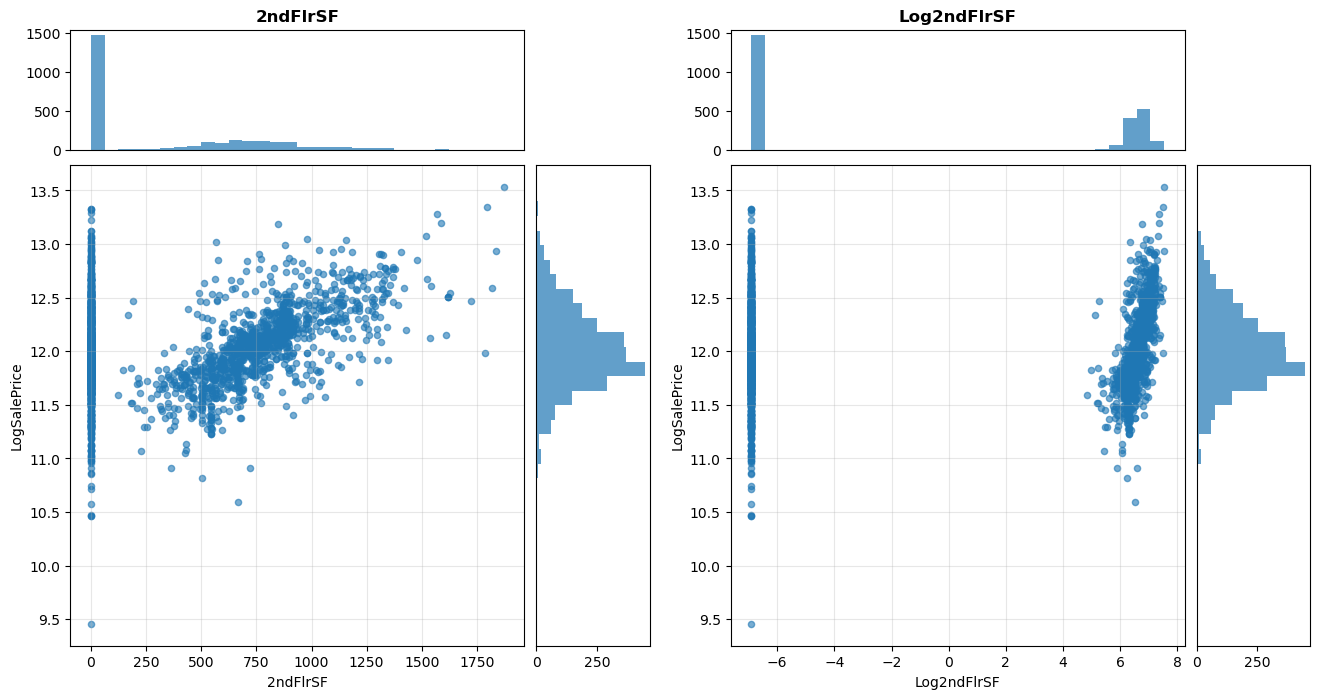

In [240]:
# Alternative simpler version using subplots
fig, axes = plt.subplots(2, 5, figsize=(16, 8), 
                        gridspec_kw={'height_ratios': [1, 4], 'width_ratios': [4, 1, 0.5, 4, 1],
                                    'hspace': 0.05, 'wspace': 0.05})

# First plot set (columns 0, 1)
axes[0, 0].hist(sf_df_vis['2ndFlrSF'], bins=30, alpha=0.7)
axes[0, 0].set_title('2ndFlrSF', fontweight='bold')
axes[0, 0].set_xticks([])

axes[1, 0].scatter(sf_df_vis['2ndFlrSF'], sf_df_vis['LogSalePrice'], alpha=0.6, s=20)
axes[1, 0].set_xlabel('2ndFlrSF')
axes[1, 0].set_ylabel('LogSalePrice')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(sf_df_vis['LogSalePrice'], bins=30, orientation='horizontal', 
                alpha=0.7)
axes[1, 1].set_yticks([])

# Second plot set (columns 3, 4)
axes[0, 3].hist(sf_df_vis['Log2ndFlrSF'], bins=30, alpha=0.7)
axes[0, 3].set_title('Log2ndFlrSF', fontweight='bold')
axes[0, 3].set_xticks([])

axes[1, 3].scatter(sf_df_vis['Log2ndFlrSF'], sf_df_vis['LogSalePrice'], alpha=0.6, s=20)
axes[1, 3].set_xlabel('Log2ndFlrSF')
axes[1, 3].set_ylabel('LogSalePrice')
axes[1, 3].grid(True, alpha=0.3)

axes[1, 4].hist(sf_df_vis['LogSalePrice'], bins=30, orientation='horizontal', 
                alpha=0.7)
axes[1, 4].set_yticks([])

# Hide the unused subplots
axes[0, 1].axis('off')
axes[0, 2].axis('off')  # Spacer column
axes[1, 2].axis('off')  # Spacer column
axes[0, 4].axis('off')

plt.show()